## 1. Librerías

In [1]:
#Importamos librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import os
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import matplotlib.dates as mdates
from cycler import cycler


import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

## 2. Estudio de las variables: tipos, estadísticos y valores nulos

In [2]:
# Cargamos los datos
med = pd.read_csv("mediciones.csv")
atm = pd.read_csv("datos_atmosfericos.csv")
med.shape, atm.shape


((53668, 6), (89784, 10))

In [3]:
# Estadísticas básicas e información adicional de los tipos de datos
print("### Mediciones")
display(med.info())
display(med.describe(include='all'))

print("### Datos Atmosféricos")
display(atm.info())
display(atm.describe(include='all'))

### Mediciones
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53668 entries, 0 to 53667
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  53668 non-null  object 
 1   estacion  53668 non-null  int64  
 2   nombre    53668 non-null  object 
 3   o3        52463 non-null  float64
 4   no2       52039 non-null  float64
 5   co        37703 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 2.5+ MB


None

,datetime,estacion,nombre,o3,no2,co
count,53668,53668.000000,53668,52463.000000,52039.000000,37703.000000
unique,18916,NaN,3,NaN,NaN,NaN
top,2025-05-31T23:00:00+02:00,NaN,ALGECIRAS EPS,NaN,NaN,NaN
freq,3,NaN,18154,NaN,NaN,NaN
mean,NaN,3392.891816,NaN,59.366411,14.542997,548.797947
std,NaN,7.481492,NaN,31.693054,16.182722,1329.854402
min,NaN,3383.000000,NaN,-19.000000,-1.000000,0.000000
25%,NaN,3383.000000,NaN,39.000000,4.000000,161.000000
50%,NaN,3395.000000,NaN,64.000000,8.000000,427.000000
75%,NaN,3401.000000,NaN,82.000000,19.000000,644.000000


### Datos Atmosféricos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89784 entries, 0 to 89783
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   time                  89784 non-null  object 
 1   temperature_2m        89784 non-null  float64
 2   direct_radiation      89784 non-null  float64
 3   wind_direction_10m    89784 non-null  int64  
 4   wind_speed_10m        89784 non-null  float64
 5   relative_humidity_2m  89784 non-null  int64  
 6   Localizacion          89784 non-null  int64  
 7   Name                  89784 non-null  object 
 8   Latitude              89784 non-null  float64
 9   Longitude             89784 non-null  float64
dtypes: float64(5), int64(3), object(2)
memory usage: 6.9+ MB


None

,time,temperature_2m,direct_radiation,wind_direction_10m,wind_speed_10m,relative_humidity_2m,Localizacion,Name,Latitude,Longitude
count,89784,89784.000000,89784.000000,89784.000000,89784.000000,89784.000000,89784.000000,89784,89784.000000,89784.000000
unique,29928,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN
top,2025-05-31T23:00,NaN,NaN,NaN,NaN,NaN,NaN,SAN FERNANDO,NaN,NaN
freq,3,NaN,NaN,NaN,NaN,NaN,NaN,29928,NaN,NaN
mean,NaN,18.421103,149.390459,182.290753,12.248075,72.712621,3393.000000,NaN,36.428457,-5.924580
std,NaN,6.024284,227.879036,98.191251,6.953320,18.968812,7.483356,NaN,0.226627,0.334993
min,NaN,-0.000000,0.000000,1.000000,0.000000,10.000000,3383.000000,NaN,36.136230,-6.203070
25%,NaN,14.100000,0.000000,96.000000,7.200000,60.000000,3383.000000,NaN,36.136230,-6.203070
50%,NaN,17.900000,1.000000,184.000000,10.900000,76.000000,3395.000000,NaN,36.460590,-6.117240
75%,NaN,22.200000,254.000000,270.000000,15.900000,89.000000,3401.000000,NaN,36.688550,-5.453430


## 3. Tratamiento de fechas



In [4]:
# Estandarizamos nombres de estaciones
atm.rename(columns={"Localizacion": "estacion"}, inplace=True)

atm["time"] = pd.to_datetime(atm["time"])

# Asegurar formatos de fecha son iguales
med["datetime"] = pd.to_datetime(med["datetime"], errors="coerce")  # Convierte, incluso si ya es tz-aware
med["datetime"] = med["datetime"].apply(lambda x: x.replace(tzinfo=None) if x is not pd.NaT else x)

atm["datetime"] = pd.to_datetime(atm["time"])
atm.drop(columns=["time"], inplace=True)
atm["nombre"] = atm["Name"]
atm.drop(columns=["Name"], inplace=True)

In [5]:
atm["datetime"].head(2)

,datetime
0,2022-01-01 00:00:00
1,2022-01-01 01:00:00


In [6]:
atm["datetime"].tail(2)

,datetime
89782,2025-05-31 22:00:00
89783,2025-05-31 23:00:00


In [7]:
med["datetime"].head(2)

,datetime
0,2022-01-01
1,2022-01-01


In [8]:
med["datetime"].tail(2)

,datetime
53666,2025-05-31 23:00:00
53667,2025-05-31 23:00:00


## 5. Análisis de Outliers



In [9]:
#Función para tratar outliers con el método IQR
def eliminar_outliers_iqr(df, col_contaminante):
    df_resultado = df.copy()

    # Asegurar que 'nombre_estacion' existe y es string
    if "nombre" not in df_resultado.columns:
        raise ValueError("La columna 'nombre' no existe en el DataFrame.")

    df_resultado["nombre"] = df_resultado["nombre"].astype(str)
    estaciones = df_resultado["nombre"].unique()

    # Paleta de colores asociada a cada estación
    palette_colores = dict(zip(estaciones, sns.color_palette("Set2", n_colors=len(estaciones))))

    outlier_col = f'outlier_iqr_{col_contaminante}'
    outliers_idx = []

    # Detección de outliers por IQR por estación
    for estacion in estaciones:
        subset = df_resultado[df_resultado["nombre"] == estacion][col_contaminante].dropna()
        q1 = subset.quantile(0.25)
        q3 = subset.quantile(0.75)
        iqr = q3 - q1
        lim_inf = q1 - 1.5 * iqr
        lim_sup = q3 + 1.5 * iqr

        idx = df_resultado[
            (df_resultado["nombre"] == estacion) &
            ((df_resultado[col_contaminante] < lim_inf) | (df_resultado[col_contaminante] > lim_sup))
        ].index

        outliers_idx.extend(idx)
        print(f"{col_contaminante.upper()} - {estacion}: {len(idx)} outliers detectados")

    #Eliminamos outliers
    df_resultado[outlier_col] = df_resultado.index.isin(outliers_idx)
    df_resultado = df_resultado[~df_resultado[outlier_col].fillna(False)].copy()
    df_resultado = df_resultado.drop(columns=[outlier_col])

    #return df_resultado
    return df

In [10]:
#Eliminamos outliers o3 por estación
df_o3 = med[["datetime", "nombre", "o3"]].copy()
med_sin_outliers_o3 = eliminar_outliers_iqr(df_o3, "o3")

O3 - ALGECIRAS EPS: 2 outliers detectados
O3 - SAN FERNANDO: 4 outliers detectados
O3 - JEREZ-CHAPMN: 2 outliers detectados


In [11]:
#Eliminamos outliers co por estación
df_co = med[["datetime", "nombre", "co"]].copy()
med_sin_outliers_co = eliminar_outliers_iqr(df_co, "co")

CO - ALGECIRAS EPS: 321 outliers detectados
CO - SAN FERNANDO: 57 outliers detectados
CO - JEREZ-CHAPMN: 1378 outliers detectados


In [12]:
#Eliminamos outliers no2 por estación
df_no2 = med[["datetime", "nombre", "no2"]].copy()
med_sin_outliers_no2 = eliminar_outliers_iqr(df_no2, "no2")

NO2 - ALGECIRAS EPS: 216 outliers detectados
NO2 - SAN FERNANDO: 1399 outliers detectados
NO2 - JEREZ-CHAPMN: 1415 outliers detectados


## 6. Completar Registros Horarios Faltantes

In [13]:
#Función para detectar registro horarios faltantes
def completar_registros_faltantes(df, frecuencia_heatmap='D'):
    """
    Completamos registros faltantes por hora y estación.
    """
    df = df.copy()
    df["datetime"] = pd.to_datetime(df["datetime"])
    df["nombre"] = df["nombre"].astype(str)

    # Rejilla horaria completa
    fechas = pd.date_range(df["datetime"].min(), df["datetime"].max(), freq='h')
    estaciones = df["nombre"].unique()
    rejilla_esperada = pd.MultiIndex.from_product([fechas, estaciones], names=["datetime", "nombre"])

    # Registros originales
    registros_originales = df.set_index(["datetime", "nombre"]).index

    # Detectar combinaciones faltantes
    combinaciones_faltantes = rejilla_esperada.difference(registros_originales)
    df_faltantes = pd.DataFrame(combinaciones_faltantes.tolist(), columns=["datetime", "nombre"])

    # Mostrar resumen
    print(f"Registros originales: {len(registros_originales)}")
    print(f"Registros tras completar rejilla horaria: {len(rejilla_esperada)}")
    print(f"Registros faltantes detectados: {len(combinaciones_faltantes)}")


    # Reindexar y devolver datos completos
    df_completo = df.set_index(["datetime", "nombre"]).reindex(rejilla_esperada).reset_index()
    return df_completo, df_faltantes

In [14]:
#Completar datos faltantes o3 por estación
df_o3 = med_sin_outliers_o3[["datetime", "nombre", "o3"]].copy()
med_o3_completo, faltantes_o3 = completar_registros_faltantes(df_o3)

Registros originales: 53668
Registros tras completar rejilla horaria: 89784
Registros faltantes detectados: 36116


In [15]:
#Completar datos faltantes co por estación
df_co = med_sin_outliers_co[["datetime", "nombre", "co"]].copy()
med_co_completo, faltantes_co = completar_registros_faltantes(df_co)

Registros originales: 53668
Registros tras completar rejilla horaria: 89784
Registros faltantes detectados: 36116


In [16]:
#Completar datos faltantes no2 por estación
df_no2 = med_sin_outliers_no2[["datetime", "nombre", "no2"]].copy()
med_no2_completo, faltantes_no2 = completar_registros_faltantes(df_no2)

Registros originales: 53668
Registros tras completar rejilla horaria: 89784
Registros faltantes detectados: 36116


In [17]:
#Función para interpolar los valores nulos
def interpolar_contaminante(df, variable):
    """
    Interpola valores NaN de un contaminante por estación usando interpolación temporal.

    """
    df = df.copy()
    df["datetime"] = pd.to_datetime(df["datetime"])
    df = df.sort_values(["nombre", "datetime"])

    interpolados = []

    for estacion, grupo in df.groupby("nombre"):
        grupo = grupo.set_index("datetime")
        grupo[variable] = grupo[variable].interpolate(method='time', limit_direction='both')
        grupo = grupo.reset_index()
        interpolados.append(grupo)

    df_interp = pd.concat(interpolados, ignore_index=True)
    return df_interp.sort_values(["nombre", "datetime"])

In [18]:
#antes de interpolar convertimos a NaN los valores negativos irreales
med_o3_completo["o3"] = med_o3_completo["o3"].apply(lambda x: np.nan if x < 0 else x)
#Interpolamos
med_o3_interp = interpolar_contaminante(med_o3_completo, "o3")
med_o3_interp.isna().sum()

,0
datetime,0
nombre,0
o3,0


In [19]:
med_co_completo["co"] = med_co_completo["co"].apply(lambda x: np.nan if x < 0 else x)
med_co_interp = interpolar_contaminante(med_co_completo, "co")
med_co_interp.isna().sum()

,0
datetime,0
nombre,0
co,0


In [20]:
med_no2_completo["no2"] = med_no2_completo["no2"].apply(lambda x: np.nan if x < 0 else x)
med_no2_interp = interpolar_contaminante(med_no2_completo, "no2")
med_no2_interp.isna().sum()

,0
datetime,0
nombre,0
no2,0


## 7. Integración y Visualización

In [21]:
#Integramos los dataframe de los tres contaminantes con el dataframe de datos
#atmosféricos.

df_temp = pd.merge(med_o3_interp, med_co_interp, on=["datetime", "nombre"], how="inner")
df_temp2 = pd.merge(df_temp, med_no2_interp, on=["datetime", "nombre"], how="inner")
df_merge = pd.merge(df_temp2, atm, on=["datetime", "nombre"], how="inner")



## Histogramas

<Figure size 1000x800 with 0 Axes>

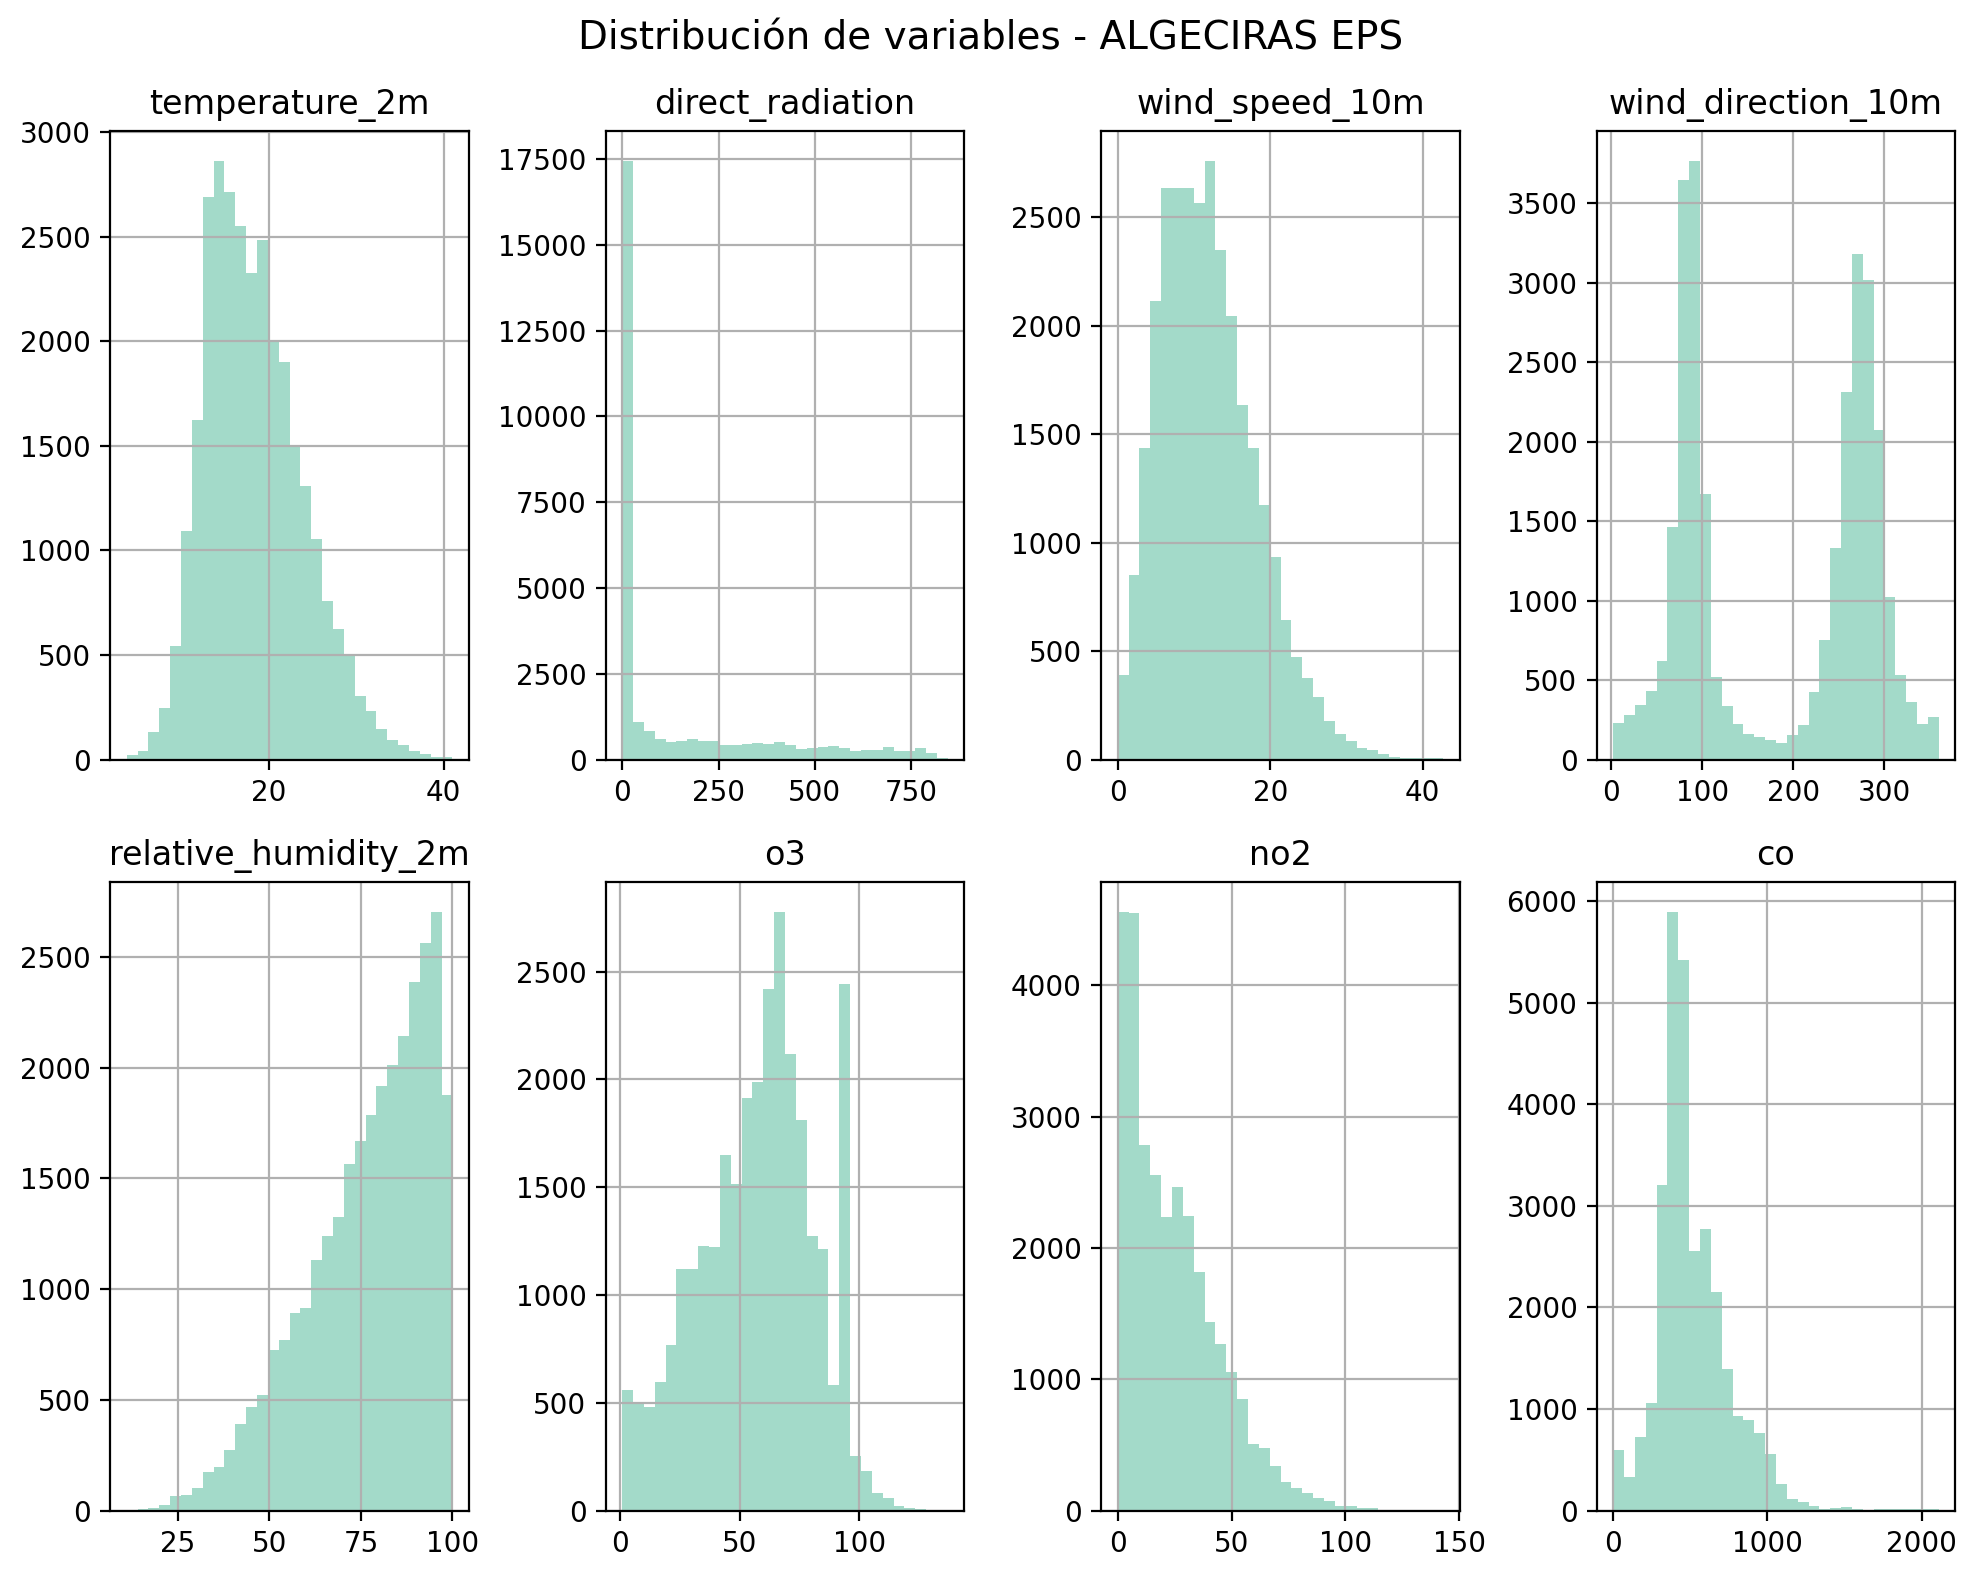

<Figure size 1000x800 with 0 Axes>

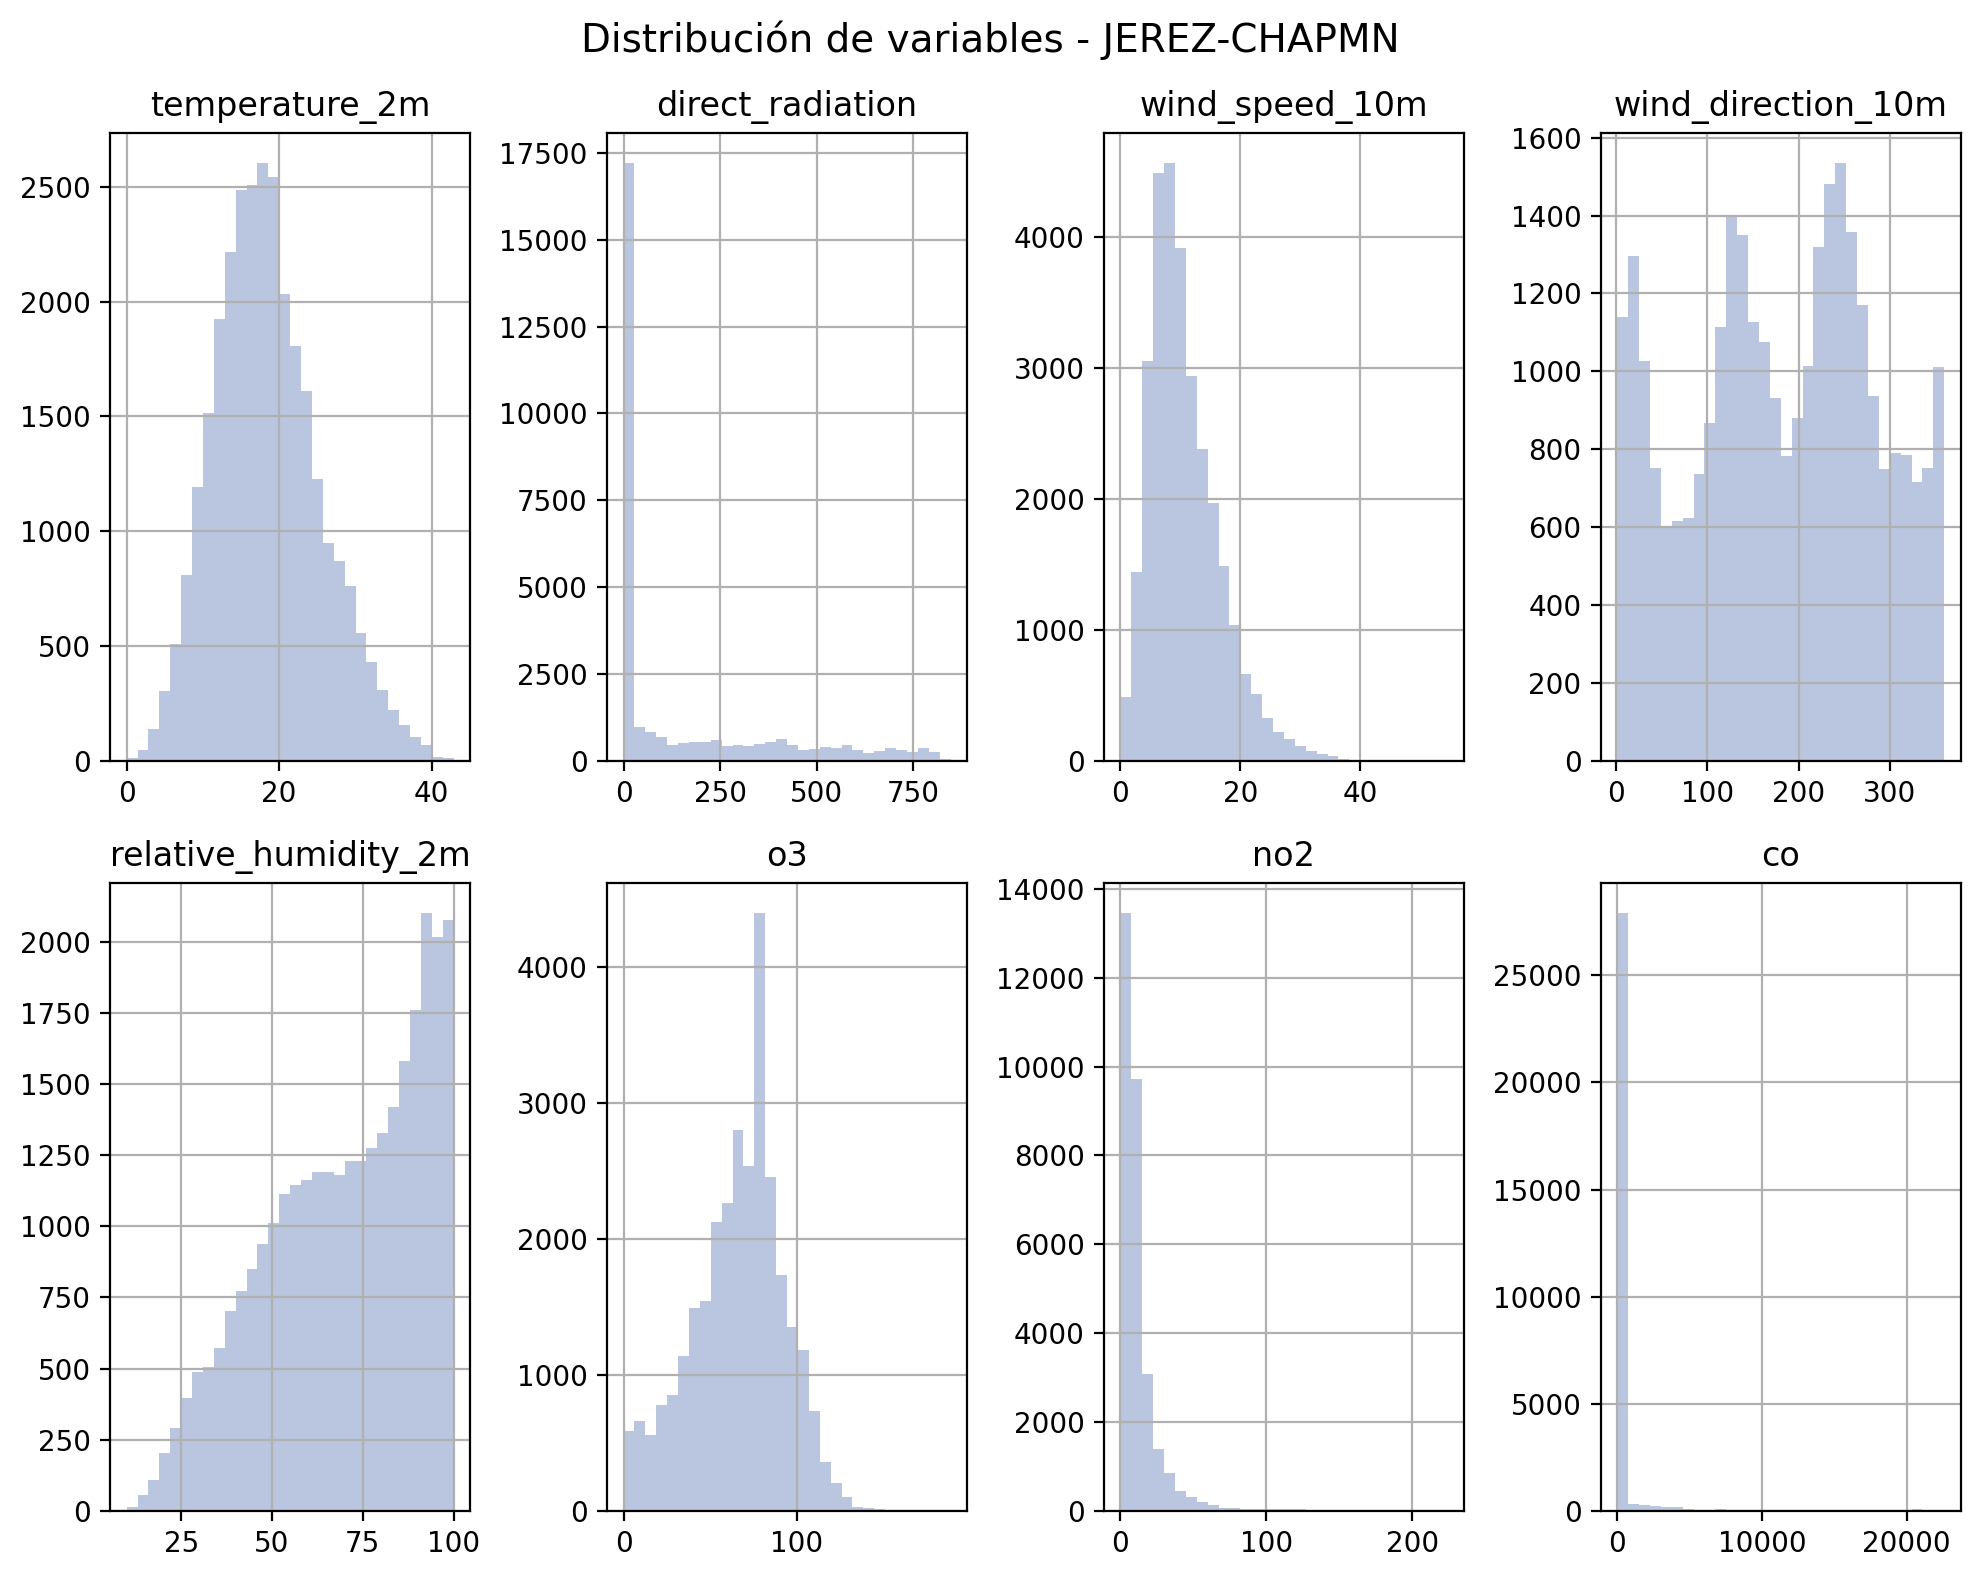

<Figure size 1000x800 with 0 Axes>

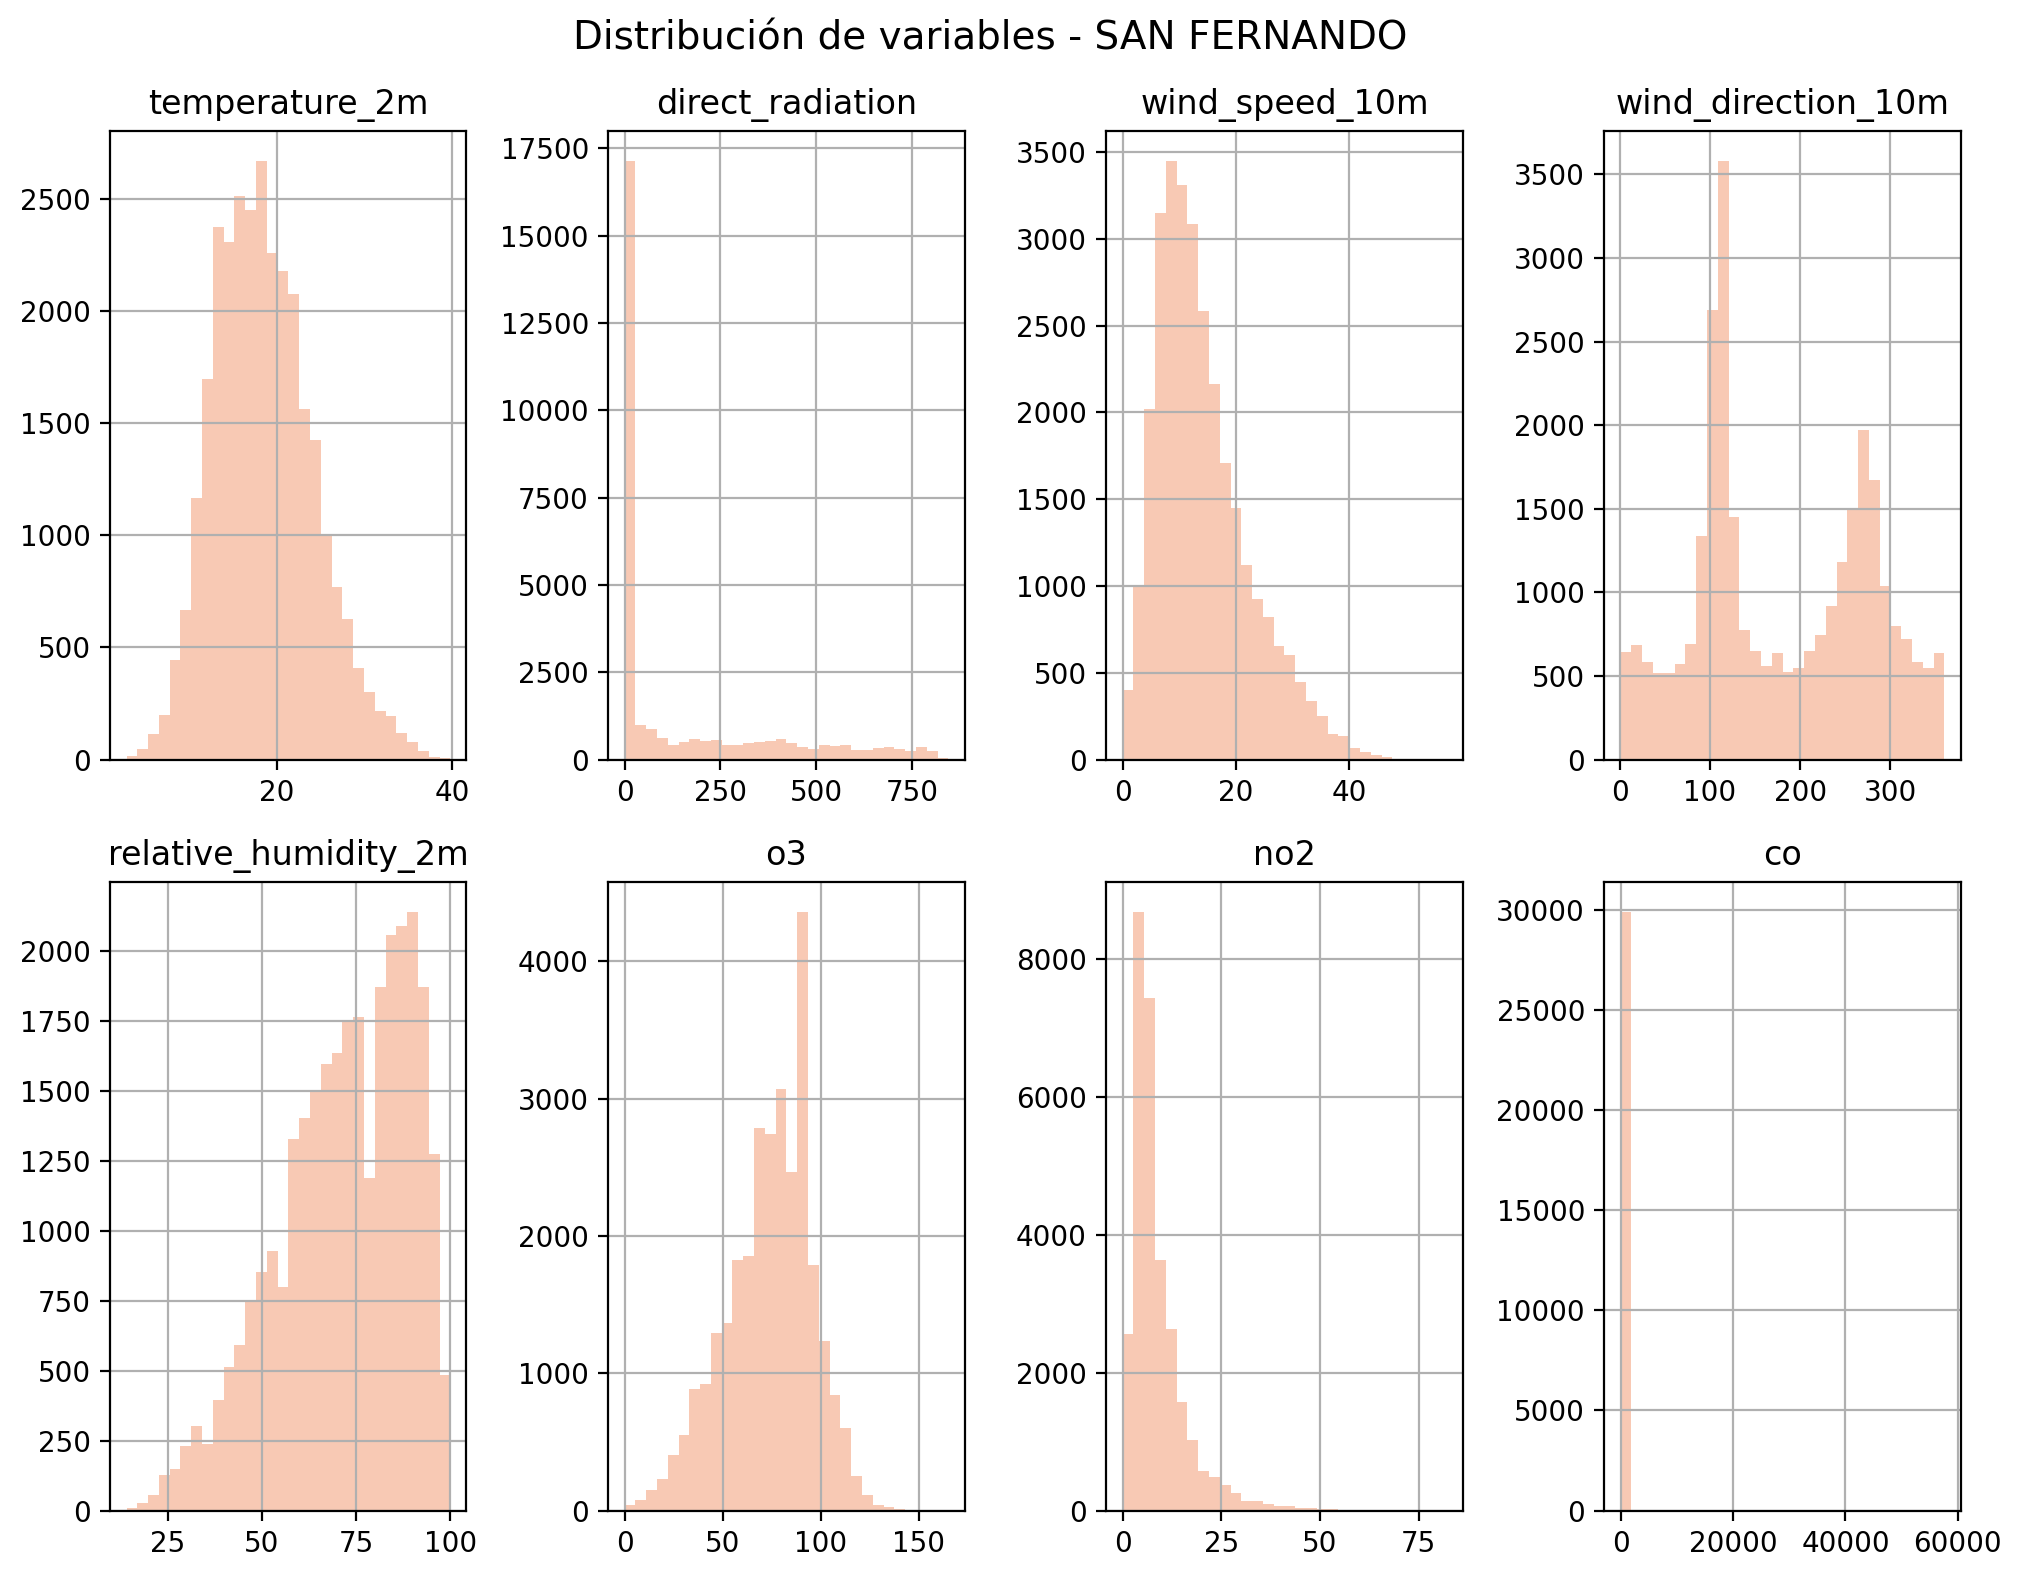

In [22]:
# Seleccionar columnas numéricas de interés
cols_of_interest = [
    "temperature_2m", "direct_radiation", "wind_speed_10m", "wind_direction_10m",
    "relative_humidity_2m", "o3", "no2", "co"
]

# Crear un directorio para guardar los histogramas
output_dir = "histogramas_por_estacion"
os.makedirs(output_dir, exist_ok=True)

# Generar un histograma para cada estación
estaciones = df_merge["nombre"].unique()

for estacion in estaciones:
    df_estacion = df_merge[df_merge["nombre"] == estacion][cols_of_interest].dropna()

    if not df_estacion.empty:
        plt.figure(figsize=(10, 8))

        if estacion == 'JEREZ-CHAPMN':
          df_estacion.hist(bins=30, layout=(2, 4), figsize=(10, 8), color="#8da0cb", alpha= 0.6)
        elif estacion == 'SAN FERNANDO':
          df_estacion.hist(bins=30, layout=(2, 4), figsize=(10, 8), color="#f4a582", alpha= 0.6)
        else:
            df_estacion.hist(bins=30, layout=(2, 4), figsize=(10, 8), color="#66c2a5", alpha= 0.6)

        plt.subplots_adjust(hspace=0.5)
        plt.suptitle(f"Distribución de variables - {estacion}", fontsize=14)
        plt.tight_layout()
        filename = f"{output_dir}/histograma_{estacion.replace(' ', '_')}.png"
        plt.savefig(filename)

## Densidades

In [23]:
output_dir = "Distribuciones_contaminantes"
os.makedirs(output_dir, exist_ok=True)

nombre_col = "nombre"  # Columna que indica la estación
# Estilo visual
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# paleta de colores
color_palette = sns.color_palette("Set2", n_colors=len(estaciones))

<Figure size 800x500 with 0 Axes>

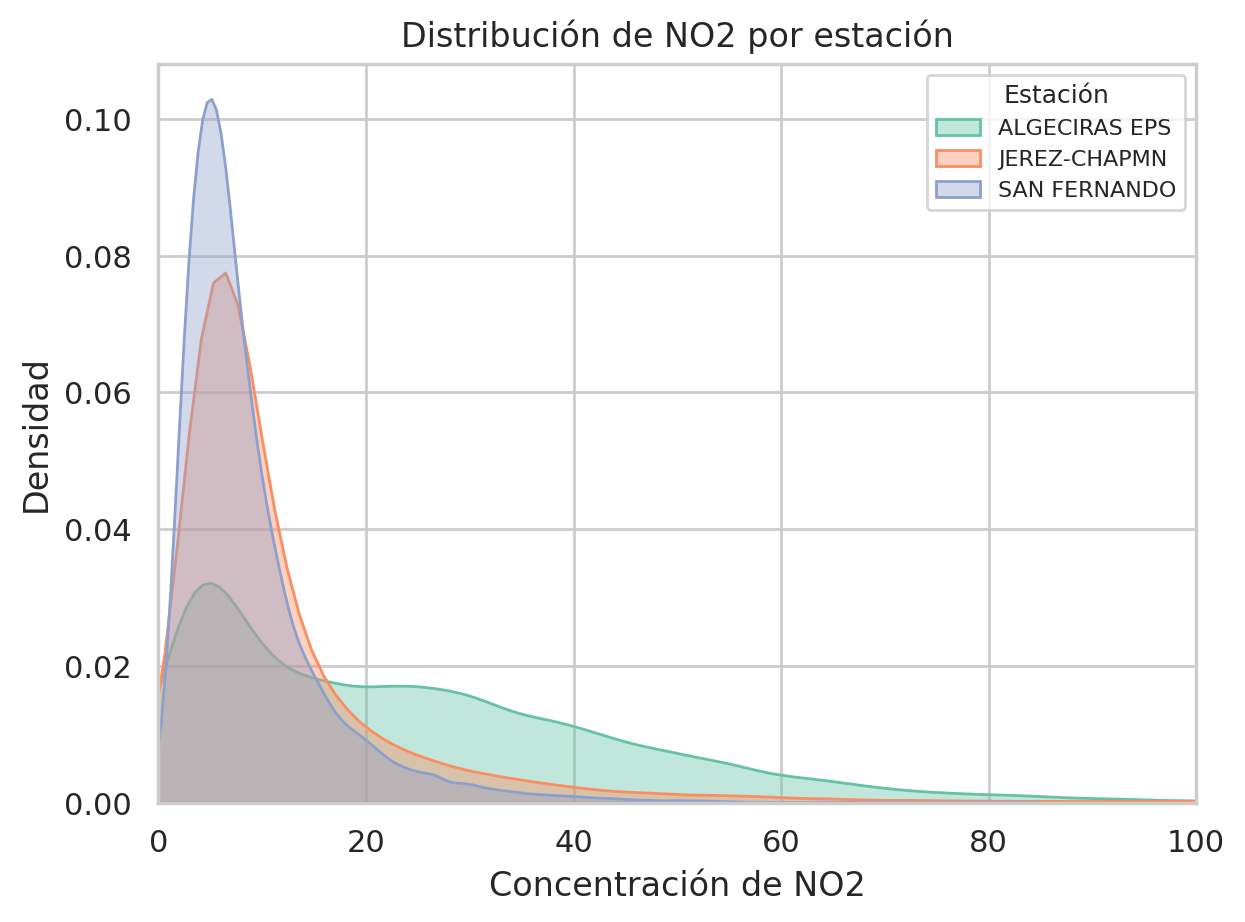

In [24]:
contaminante = "no2"

# === GRAFICADO POR ESTACIÓN ===
for i, estacion in enumerate(estaciones):
    data = df_merge[df_merge[nombre_col] == estacion][contaminante]

    # Limpieza estricta: conversión a numérico, quitar NaNs e infinitos
    data = pd.to_numeric(data, errors="coerce").dropna()
    data = data[np.isfinite(data)]

    if not data.empty:
        sns.kdeplot(
            x=data,
            label=estacion,
            fill=True,
            alpha=0.4,
            color=color_palette[i]
        )

# Ajustar eje X a percentiles 1%-99% para evitar extremos
p1 = df_merge[contaminante].quantile(0.01)
p99 = df_merge[contaminante].quantile(0.99)
plt.xlim(p1, p99)

# Etiquetas y diseño
plt.title(f"Distribución de {contaminante.upper()} por estación", fontsize=12)
plt.xlabel(f"Concentración de {contaminante.upper()}")
plt.ylabel("Densidad")
plt.legend(title="Estación", fontsize=8, title_fontsize=9)
plt.xlim(0, 100)
plt.tight_layout()

# Guardar y mostrar
plt.savefig(f"{output_dir}/densidad_{contaminante}.png")
plt.show()

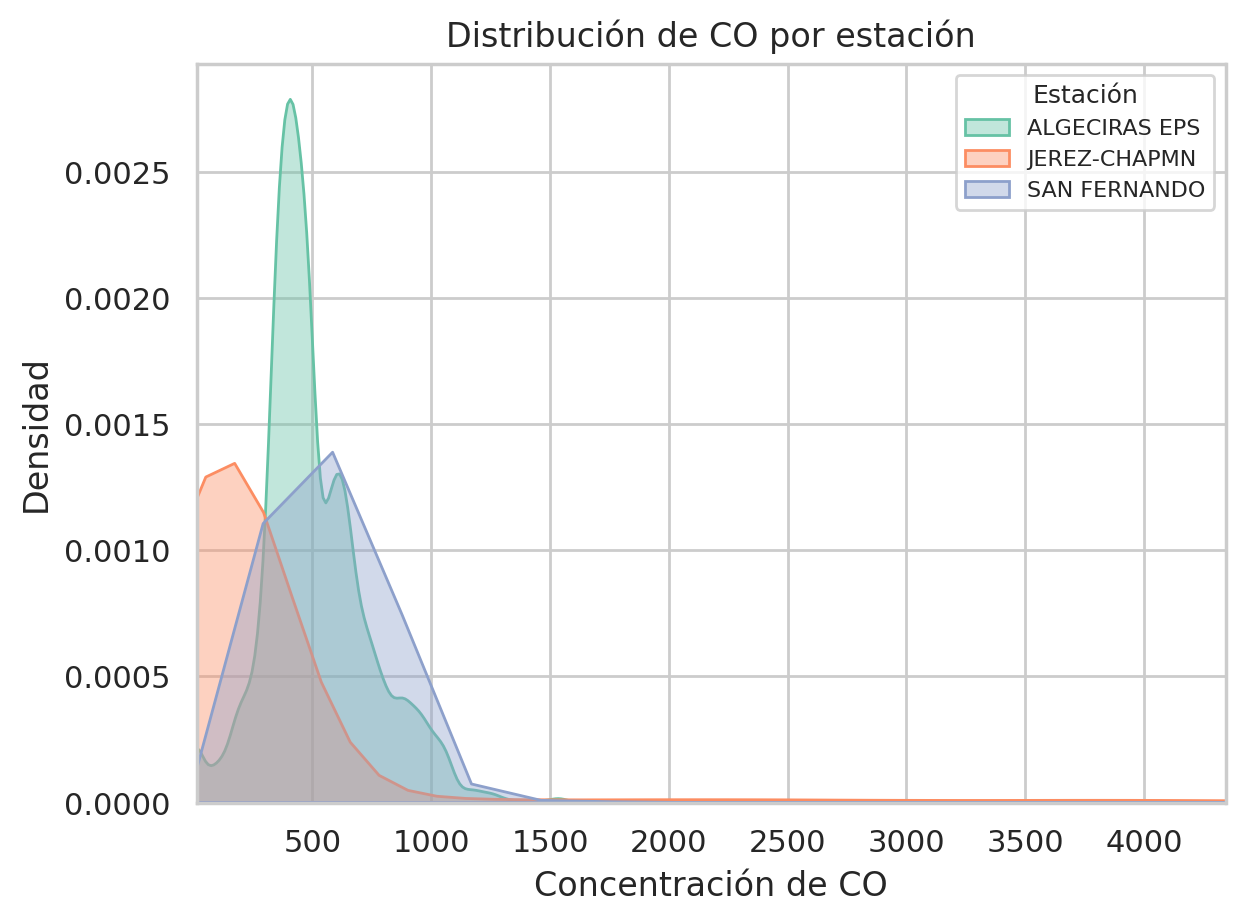

In [25]:
contaminante = "co"

# === GRAFICADO POR ESTACIÓN ===
for i, estacion in enumerate(estaciones):
    data = df_merge[df_merge[nombre_col] == estacion][contaminante]

    # Limpieza estricta: conversión a numérico, quitar NaNs e infinitos
    data = pd.to_numeric(data, errors="coerce").dropna()
    data = data[np.isfinite(data)]

    if not data.empty:
        sns.kdeplot(
            x=data,
            label=estacion,
            fill=True,
            alpha=0.4,
            color=color_palette[i]
        )

# Ajustar eje X a percentiles 1%-99% para evitar extremos
p1 = df_merge[contaminante].quantile(0.01)
p99 = df_merge[contaminante].quantile(0.99)
plt.xlim(p1, p99)

# Etiquetas y diseño
plt.title(f"Distribución de {contaminante.upper()} por estación", fontsize=12)
plt.xlabel(f"Concentración de {contaminante.upper()}")
plt.ylabel("Densidad")
plt.legend(title="Estación", fontsize=8, title_fontsize=9)
plt.tight_layout()

# Guardar y mostrar
plt.savefig(f"{output_dir}/densidad_{contaminante}.png")
plt.show()

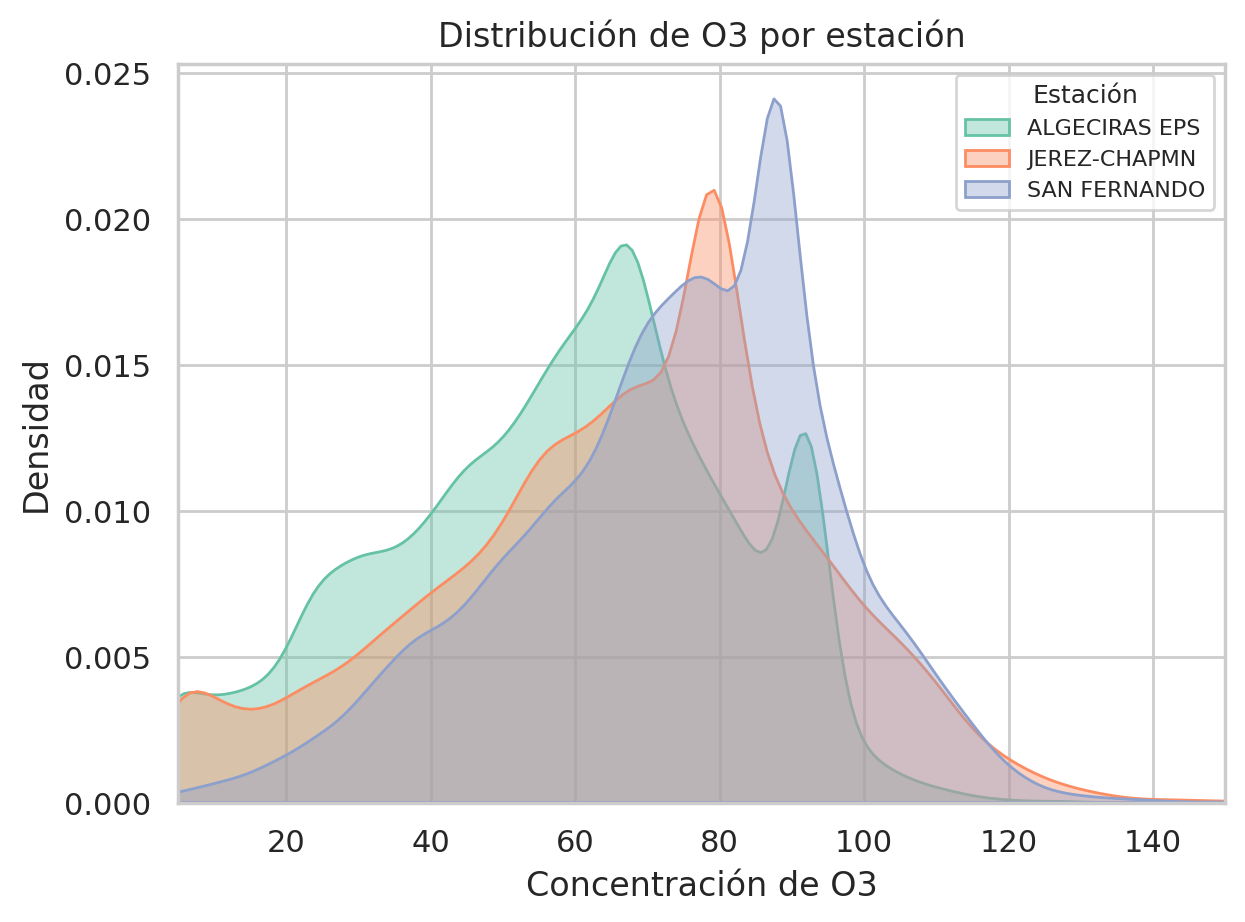

In [26]:
contaminante = "o3"

# === GRAFICADO POR ESTACIÓN ===
for i, estacion in enumerate(estaciones):
    data = df_merge[df_merge[nombre_col] == estacion][contaminante]

    # Limpieza estricta: conversión a numérico, quitar NaNs e infinitos
    data = pd.to_numeric(data, errors="coerce").dropna()
    data = data[np.isfinite(data)]

    if not data.empty:
        sns.kdeplot(
            x=data,
            label=estacion,
            fill=True,
            alpha=0.4,
            color=color_palette[i]
        )

# Ajustar eje X a percentiles 1%-99% para evitar extremos
p1 = df_merge[contaminante].quantile(0.01)
p99 = df_merge[contaminante].quantile(0.99)
plt.xlim(p1, 150)

# Etiquetas y diseño
plt.title(f"Distribución de {contaminante.upper()} por estación", fontsize=12)
plt.xlabel(f"Concentración de {contaminante.upper()}")
plt.ylabel("Densidad")
plt.legend(title="Estación", fontsize=8, title_fontsize=9)
plt.tight_layout()

# Guardar y mostrar
plt.savefig(f"{output_dir}/densidad_{contaminante}.png")
plt.show()

## Correlación  

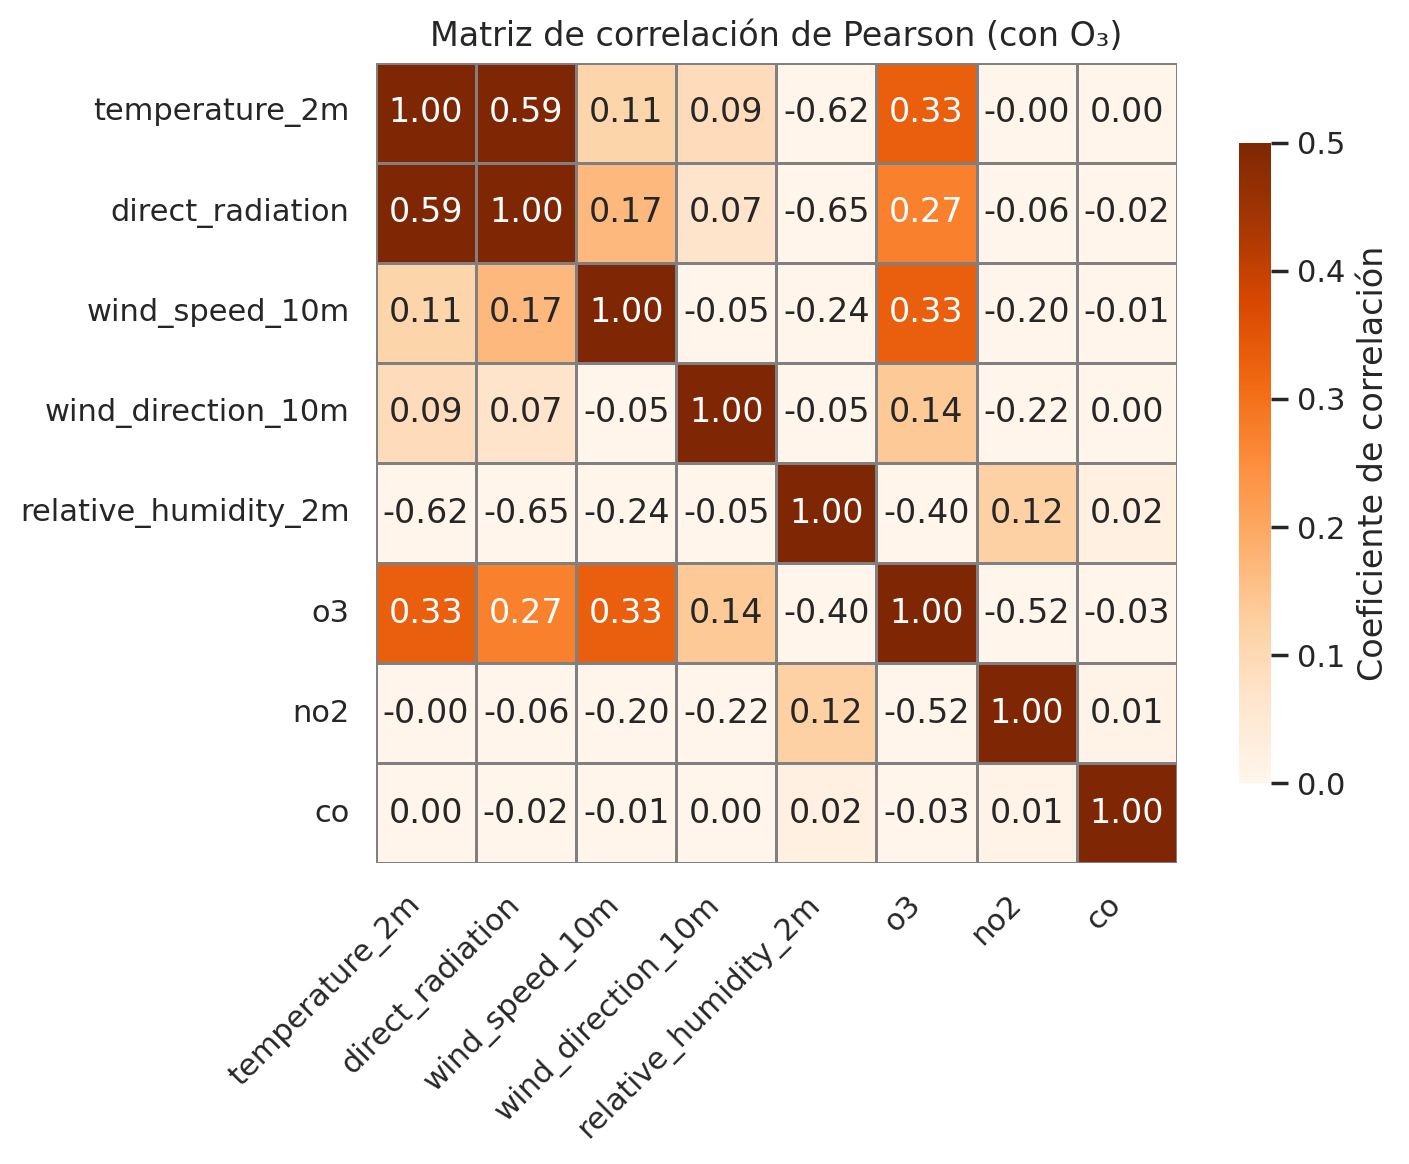

In [27]:
#Matriz de correlación de Pearson de las variables atmosféricas y de contaminación
# Estilo visual uniforme
sns.set(style="whitegrid", font_scale=1.0)


# Variables a analizar
variables = [
    "temperature_2m", "direct_radiation", "wind_speed_10m",
    "wind_direction_10m", "relative_humidity_2m", "o3", "no2", "co"
]

# Filtramos DataFrame y calcular matriz de correlación
df_corr = df_merge[variables].copy()
corr_matrix = df_corr.corr(method="pearson")

# Gráfico
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='Oranges',
    fmt=".2f",
    vmin=0,
    vmax=0.5,
    linewidths=0.5,
    linecolor="gray",
    square=True,
    cbar_kws={"shrink": 0.8, "label": "Coeficiente de correlación"}
)

plt.title("Matriz de correlación de Pearson (con O₃)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [28]:
corr_matrix["o3"]

,o3
temperature_2m,0.330303
direct_radiation,0.270252
wind_speed_10m,0.331214
wind_direction_10m,0.138296
relative_humidity_2m,-0.397009
o3,1.000000
no2,-0.517717
co,-0.030077


## 8. Descomposición TSL de las Series

In [29]:
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1
style = {
   'figure.facecolor': '#FFFFFF',
    'axes.facecolor': '#FFFFFF',
    'savefig.facecolor':'#FFFFFF',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': True,
    'axes.spines.right': True,
    'axes.spines.top': True,
    'axes.spines.bottom': True,
    'axes.linewidth': 0.3,
    'axes.labelcolor': '0.8',
    'grid.color': '#000000',
    'grid.linewidth': '0.3',
    'text.color': '0',
    'axes.labelcolor': '0',
    'xtick.color': '0',
    'ytick.color': '0',
    'font.size': 2 }
plt.rcParams.update(style)

In [30]:
# Solo 'datetime' y 'o3'
df_o3 = df_merge.loc[:, ["datetime", "o3", "nombre"]].copy()

# Filtramos por estación y seleccionamos la columna de interés
o3_alge = df_o3[df_o3 ["nombre"] == "ALGECIRAS EPS"]
o3_alge = o3_alge.drop(columns=["nombre"])
o3_alge["datetime"] = pd.to_datetime(o3_alge["datetime"], errors="coerce")
o3_alge.set_index("datetime", inplace=True)

# Filtramos por estación y seleccionamos la columna de interés
o3_sf = df_o3[df_o3 ["nombre"] == "SAN FERNANDO"]
o3_sf = o3_sf.drop(columns=["nombre"])
o3_sf["datetime"] = pd.to_datetime(o3_sf["datetime"], errors="coerce")
o3_sf.set_index("datetime", inplace=True)

# Filtramos por estación y seleccionamos la columna de interés
o3_xr = df_o3[df_o3 ["nombre"] == "JEREZ-CHAPMN"]
o3_xr = o3_xr.drop(columns=["nombre"])
o3_xr["datetime"] = pd.to_datetime(o3_xr["datetime"], errors="coerce")
o3_xr.set_index("datetime", inplace=True)


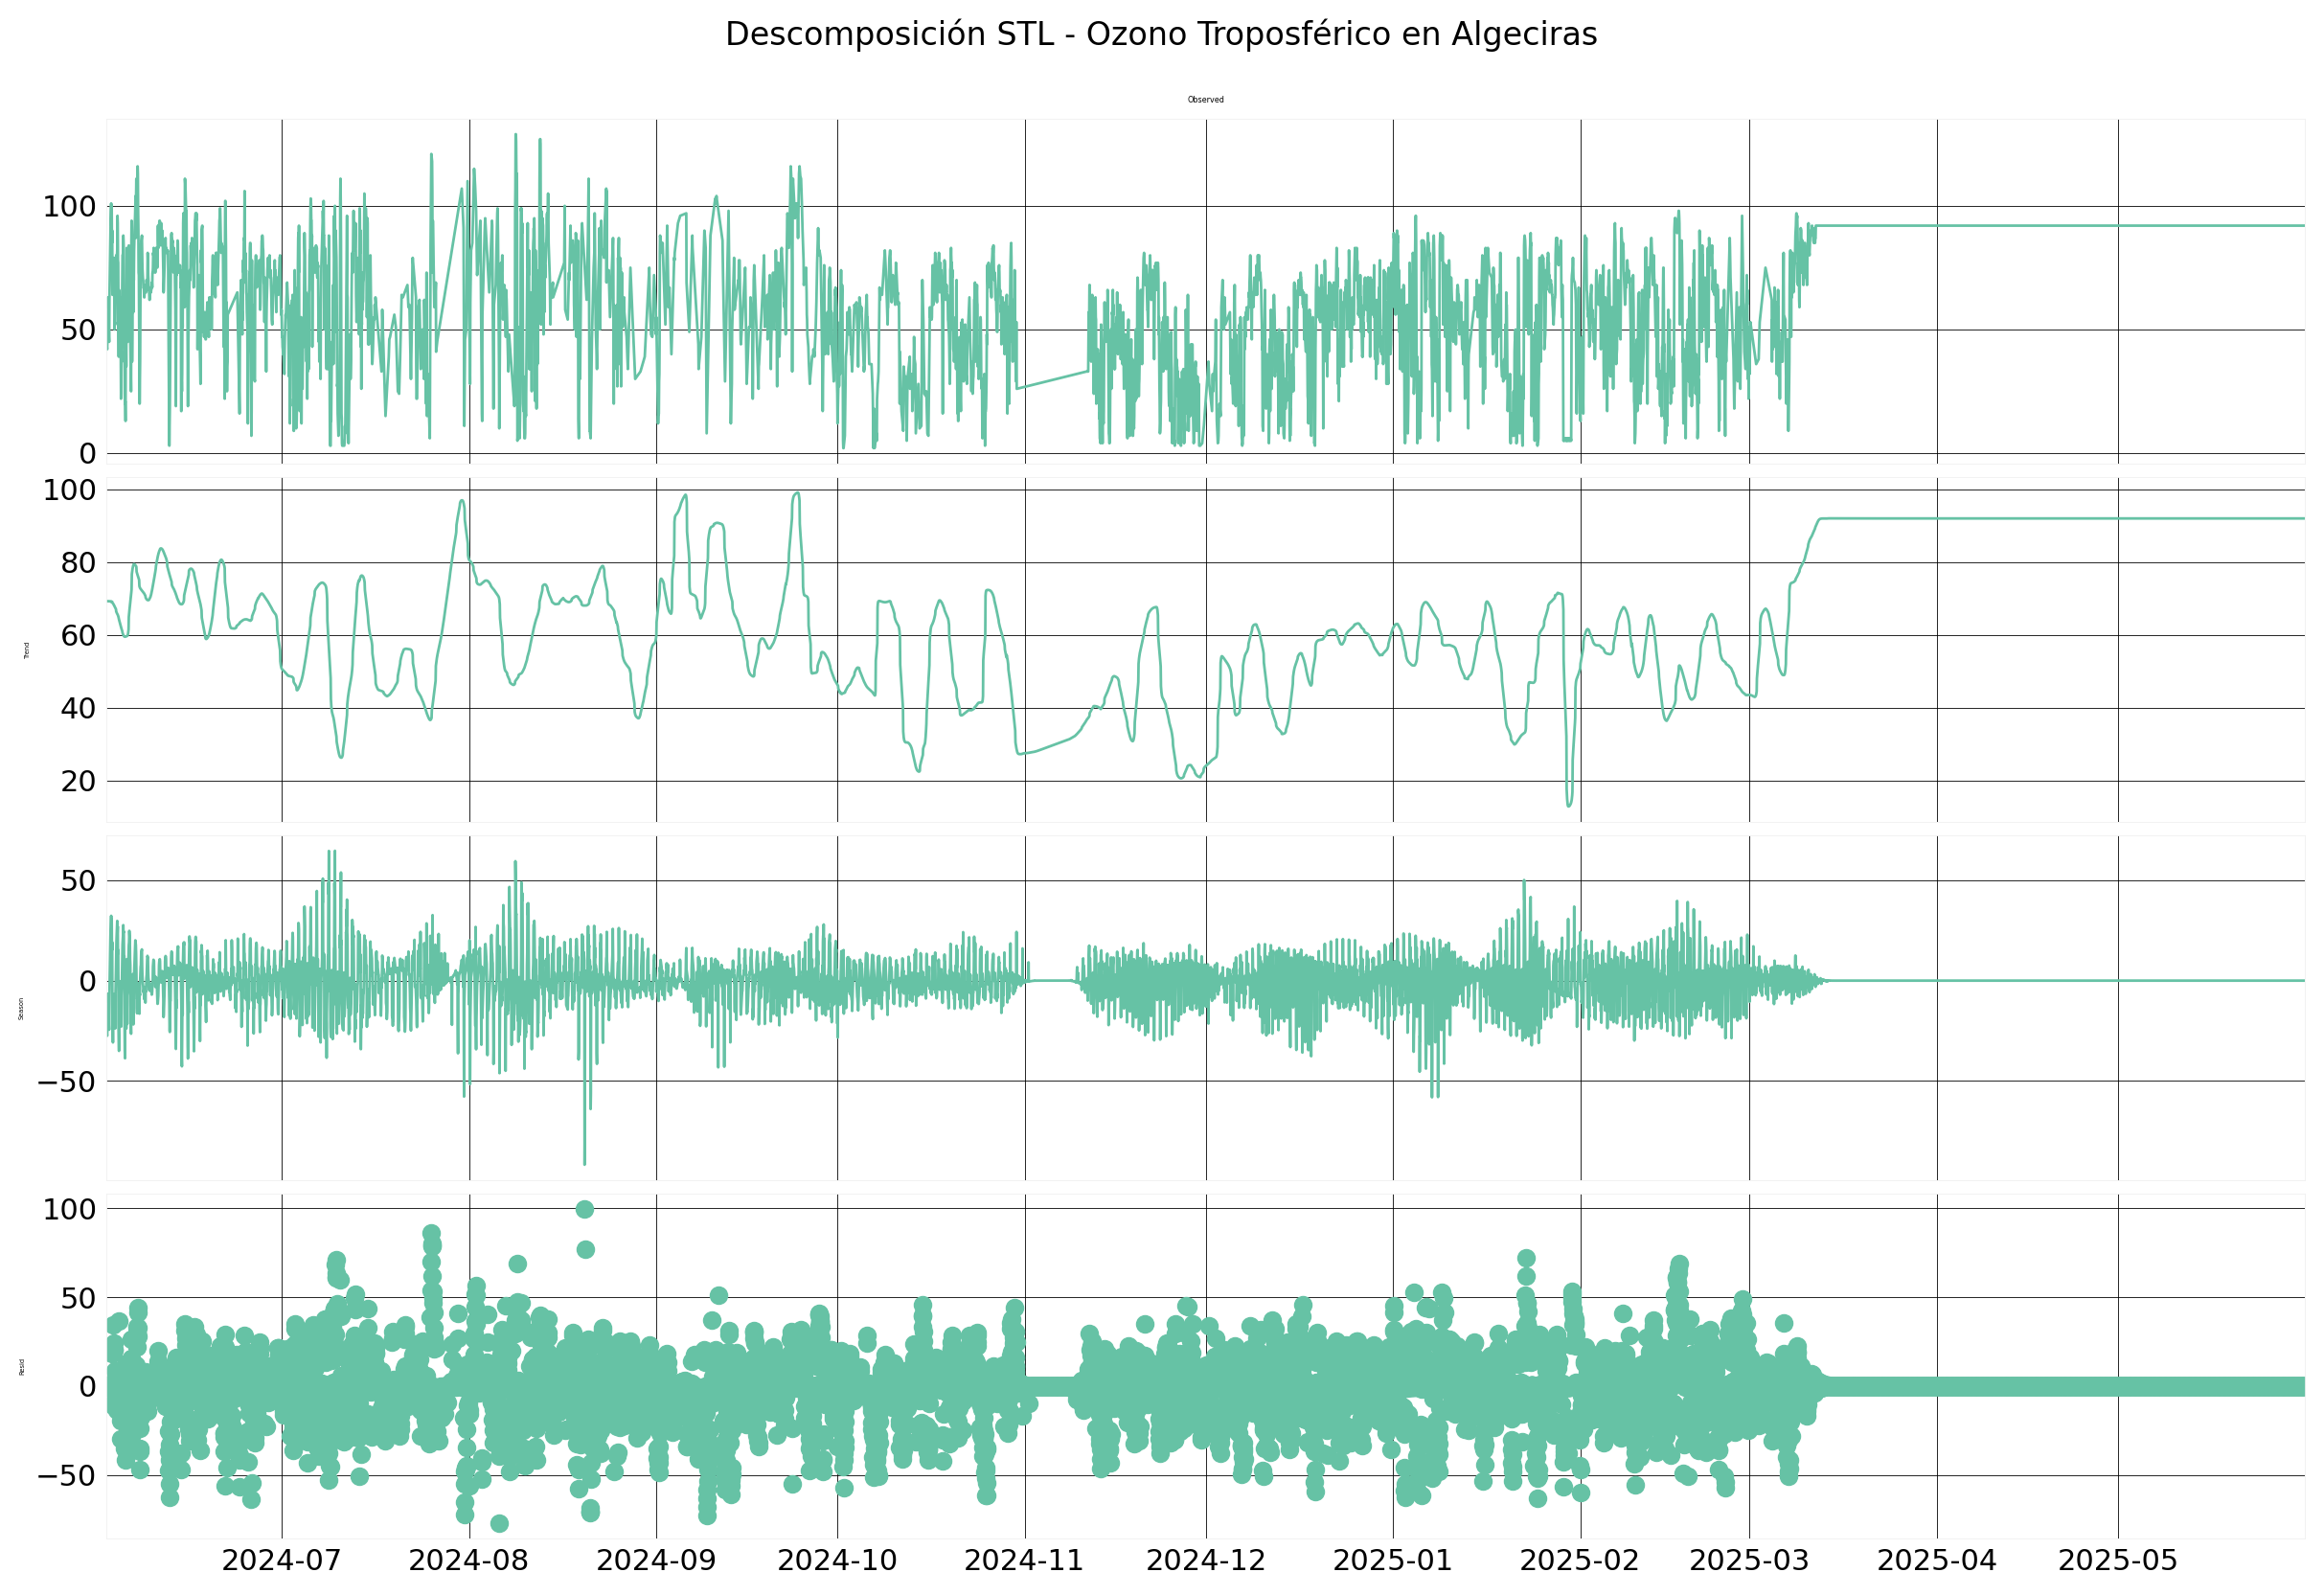

In [31]:
# Color para Algeciras
COLOR = '#66c2a5'

plt.rcParams['axes.prop_cycle'] = cycler(color=[COLOR])
plt.rcParams['lines.linewidth'] = 1

# Descomponer la serie temporal
serie_filtrada = o3_alge["2024-06-01 23:00:00":"2025-5-31 23:00:00"]
stl = STL(serie_filtrada, period=24, robust=True)
result = stl.fit()
fig = result.plot()
fig.set_size_inches(12, 8)  # ancho, alto en pulgadas
fig.suptitle('Descomposición STL - Ozono Troposférico en Algeciras', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

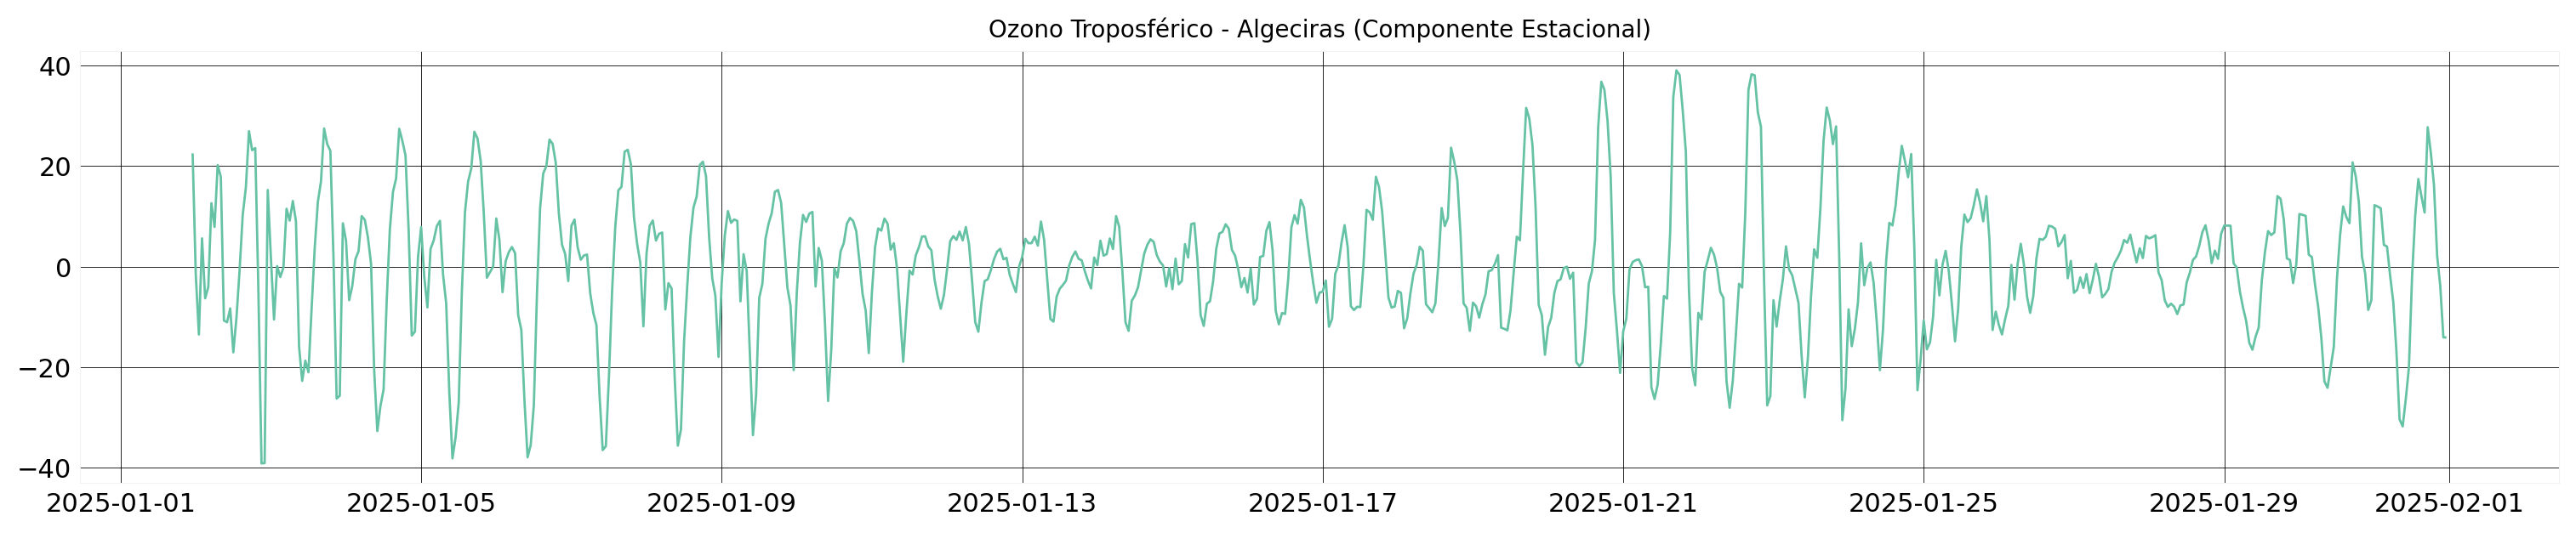

In [32]:
#Detalle componente estacional o3 Algeciras
serie_filtrada = o3_alge["2025-01-01 23:00:00":"2025-01-31 23:00:00"]
stl = STL(serie_filtrada, period=24, robust=True)
result = stl.fit()

fig, ax = plt.subplots(figsize=(15,3))
ax.plot(result.seasonal.index, result.seasonal.values)
ax.set_title('Ozono Troposférico - Algeciras (Componente Estacional)', fontsize=10)
plt.tight_layout()
plt.show()

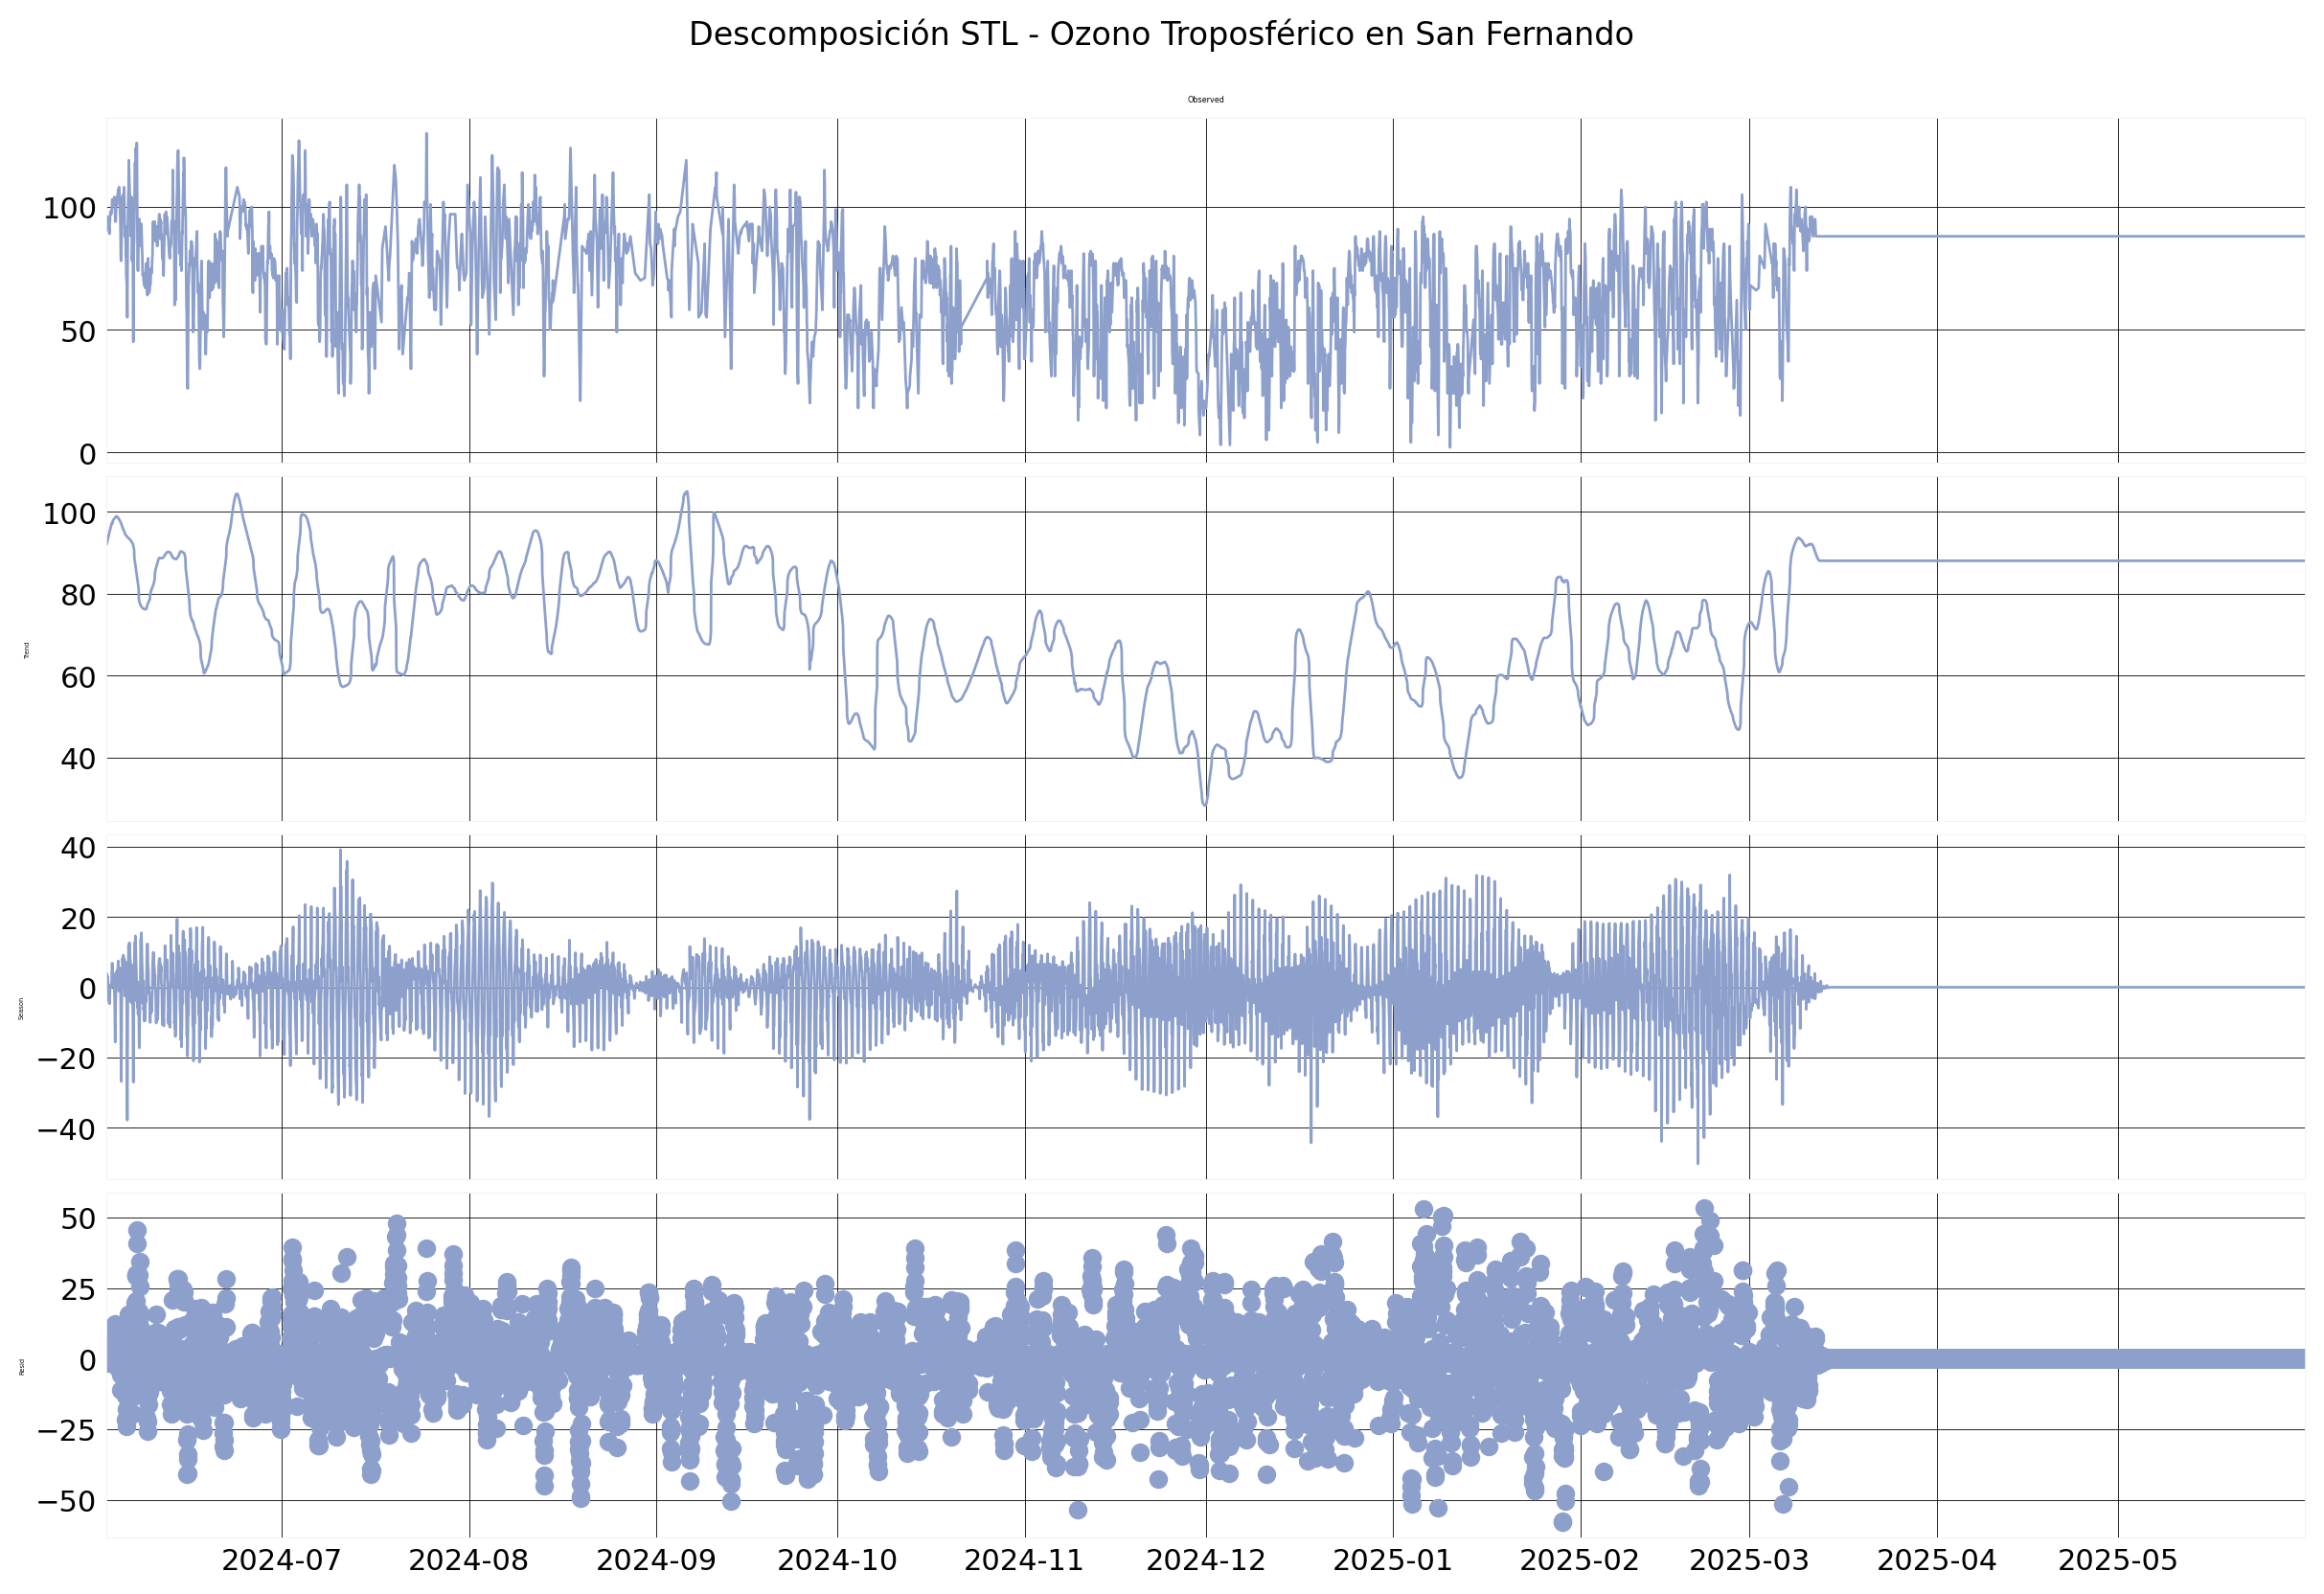

In [33]:
# Color San Fernando
COLOR = '#8da0cb'

plt.rcParams['axes.prop_cycle'] = cycler(color=[COLOR])
plt.rcParams['lines.linewidth'] = 1

# Descomponer la serie temporal
serie_filtrada = o3_sf["2024-06-01 23:00:00":"2025-5-31 23:00:00"]
stl = STL(serie_filtrada, period=24, robust=True)
result = stl.fit()
fig = result.plot()
fig.set_size_inches(12, 8)  # ancho, alto en pulgadas
fig.suptitle('Descomposición STL - Ozono Troposférico en San Fernando', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()


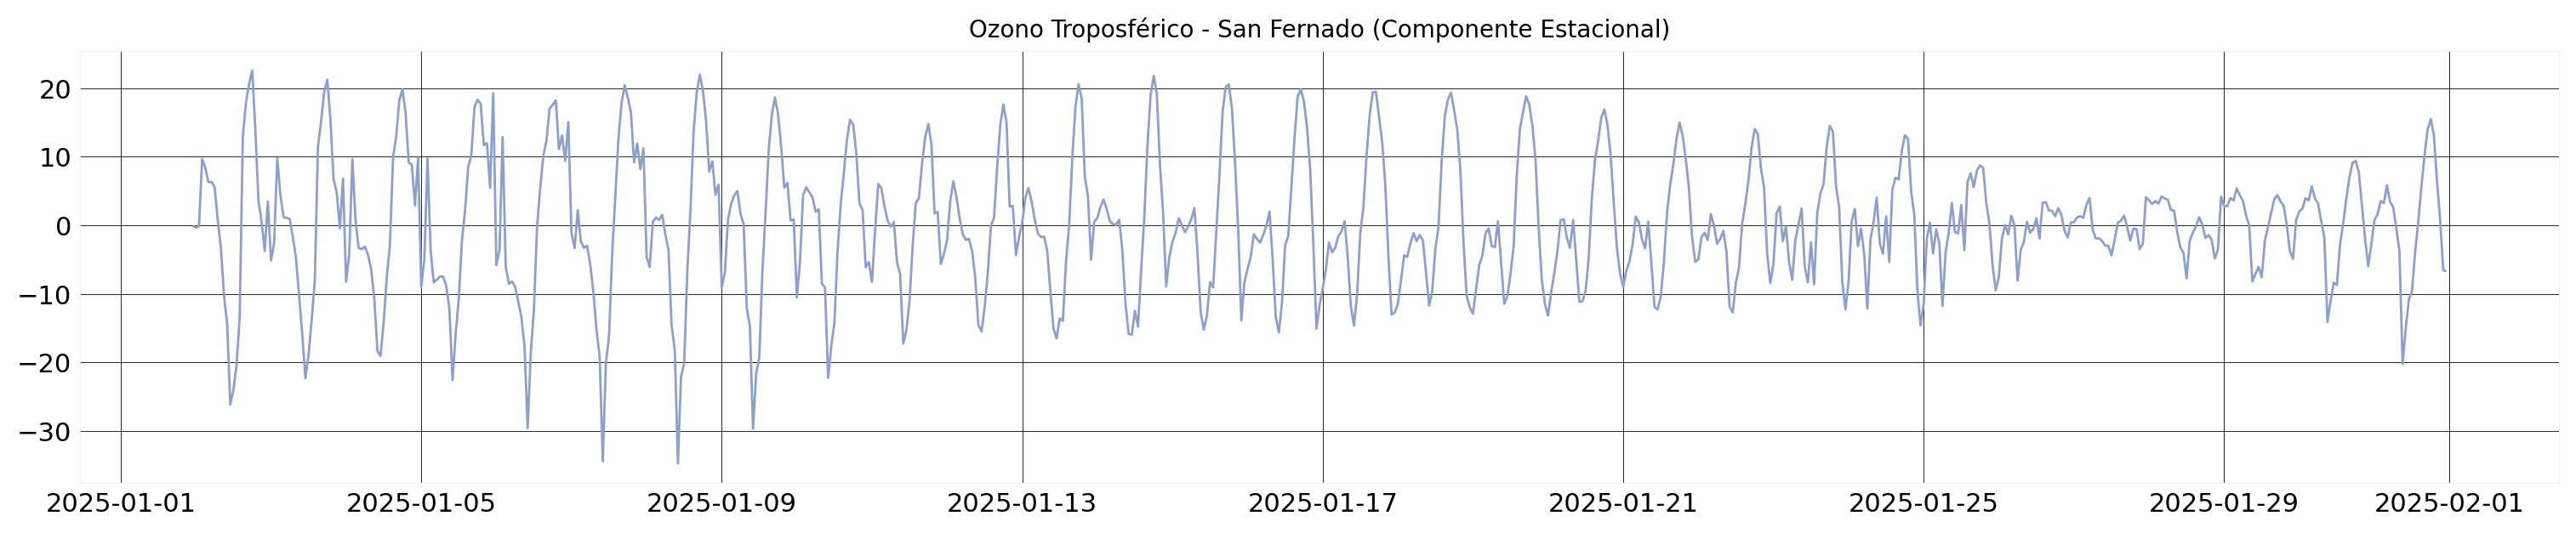

In [34]:
#Detalle componente estacional San Fernando
serie_filtrada = o3_sf["2025-01-01 23:00:00":"2025-01-31 23:00:00"]
stl = STL(serie_filtrada, period=24, robust=True)
result = stl.fit()

fig, ax = plt.subplots(figsize=(15,3))
ax.plot(result.seasonal.index, result.seasonal.values)
ax.set_title('Ozono Troposférico - San Fernado (Componente Estacional)', fontsize=10)
plt.tight_layout()
plt.show()

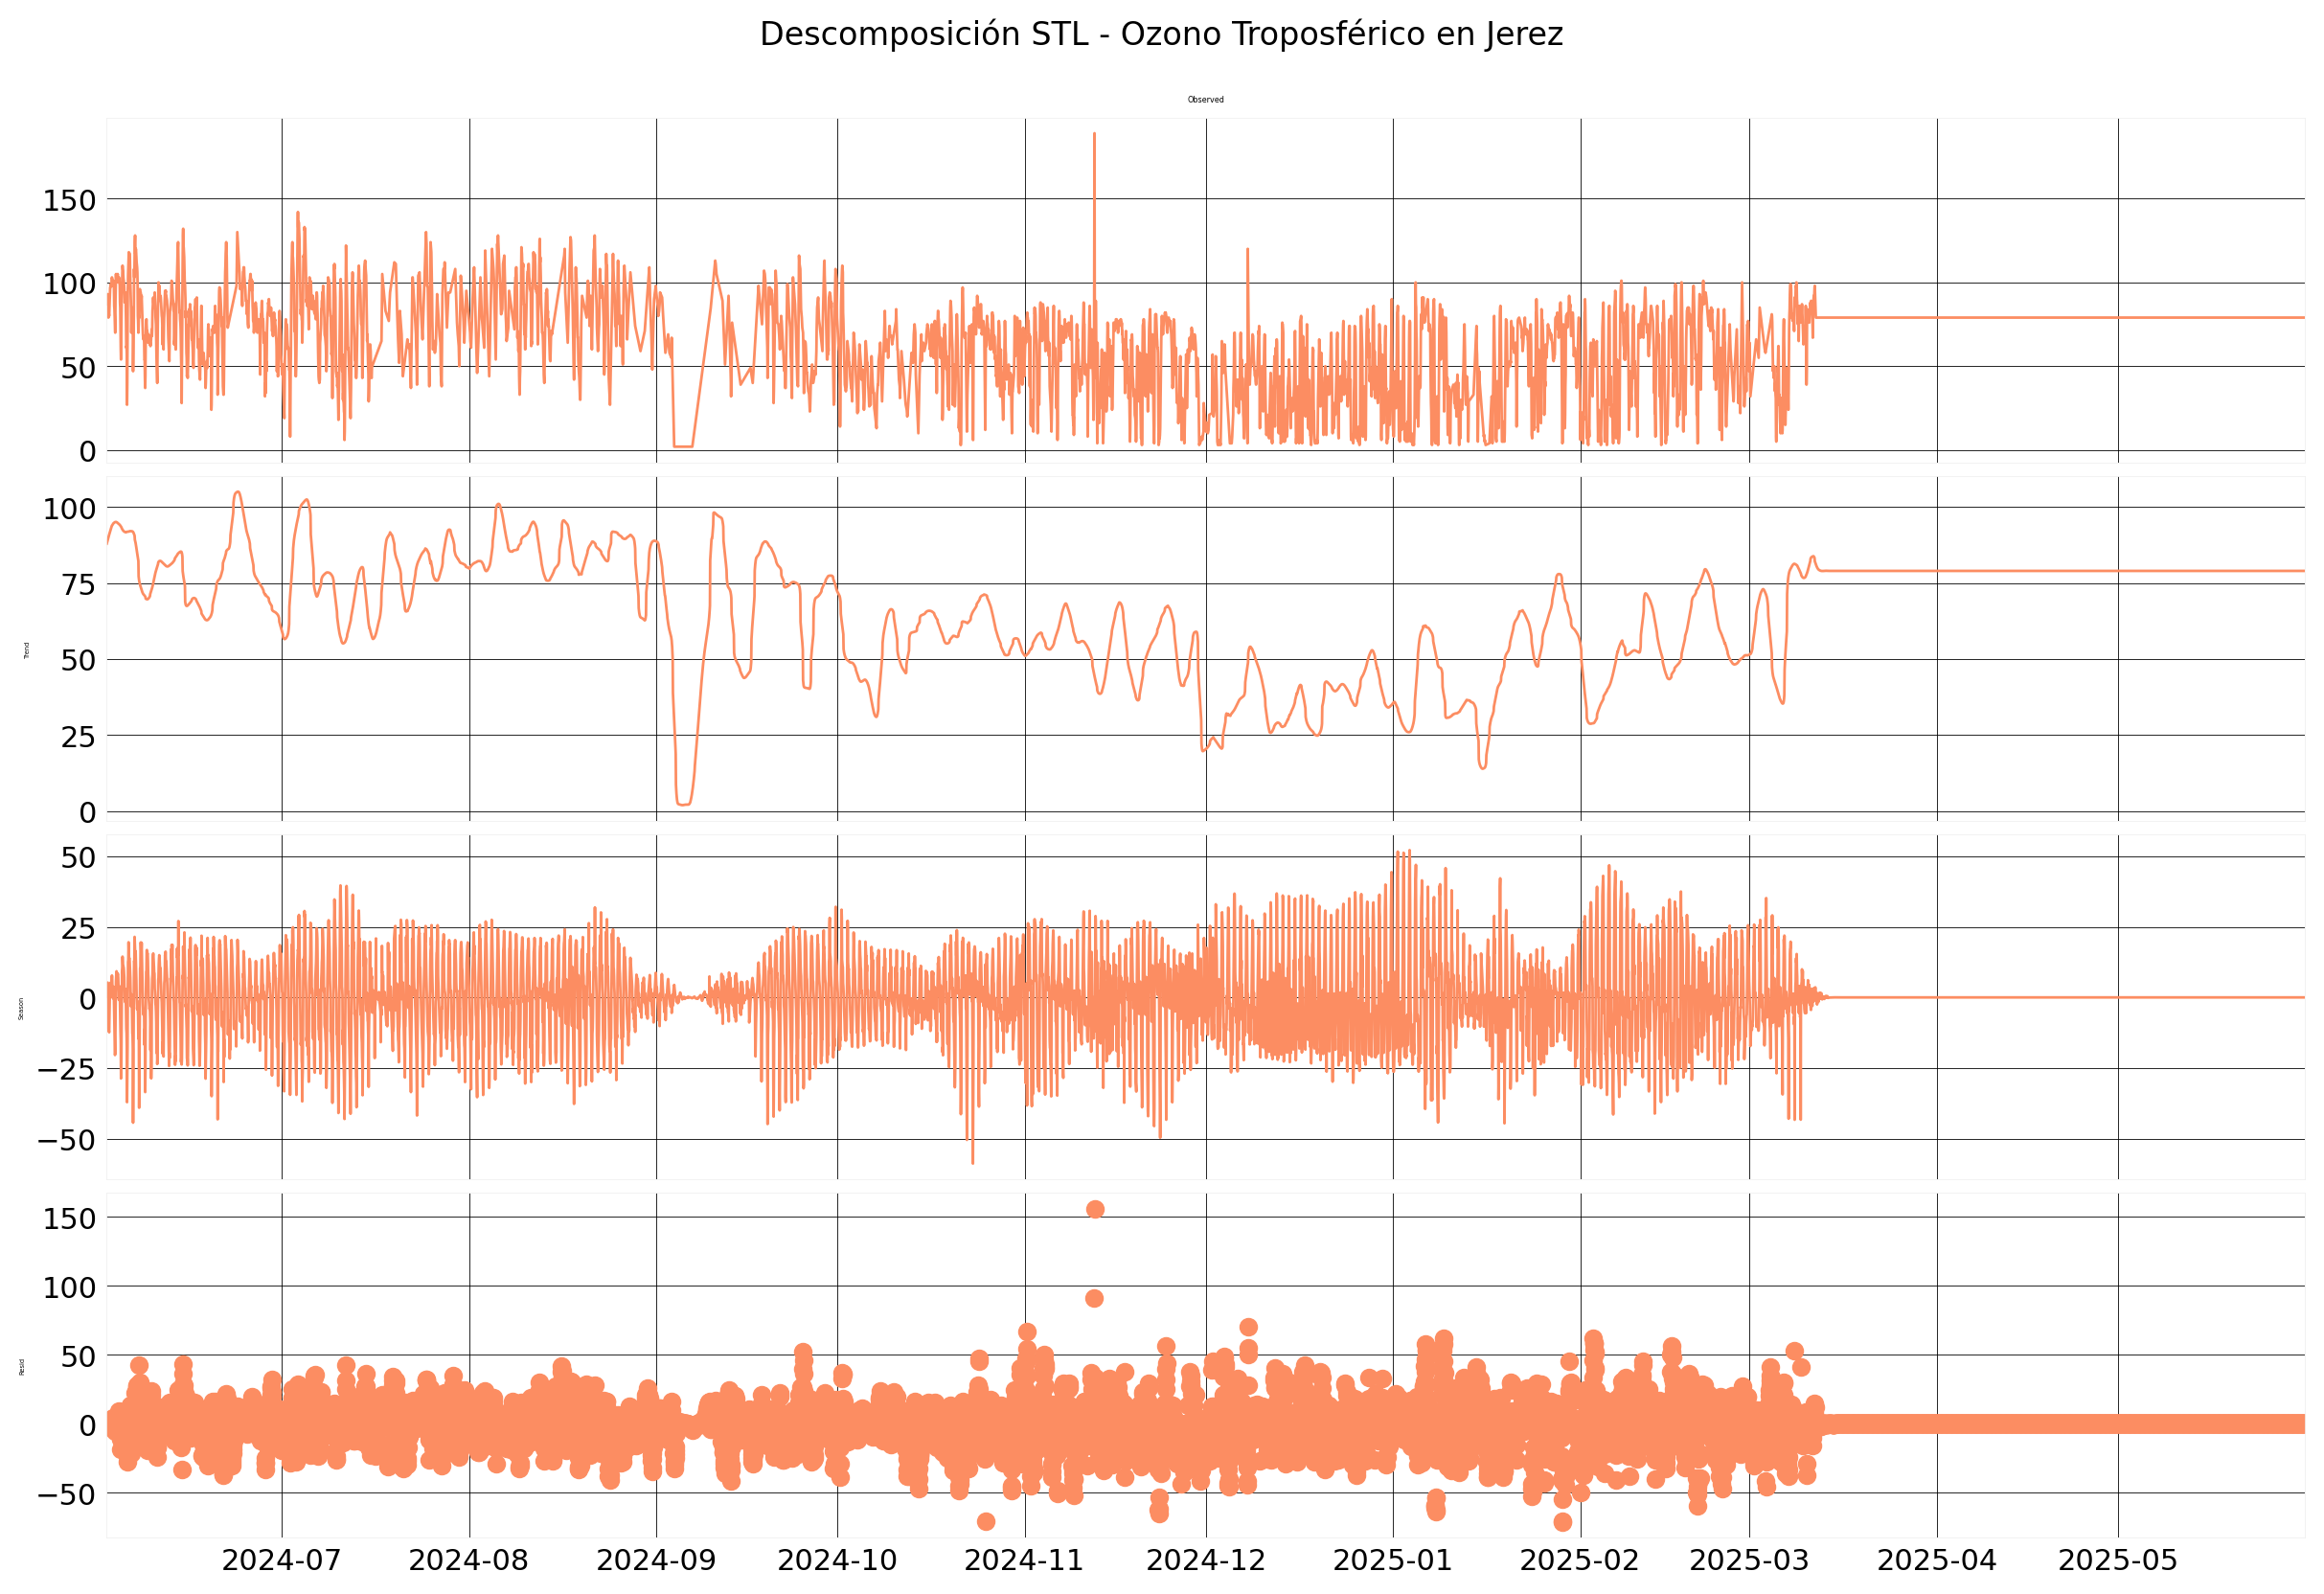

In [35]:
# Color para Jerez
COLOR = '#fc8d62'

plt.rcParams['axes.prop_cycle'] = cycler(color=[COLOR])
plt.rcParams['lines.linewidth'] = 1

# Descomponer la serie temporal
serie_filtrada = o3_xr["2024-06-01 23:00:00":"2025-5-31 23:00:00"]
stl = STL(serie_filtrada, period=24, robust=True)
result = stl.fit()
fig = result.plot()
fig.set_size_inches(12, 8)  # ancho, alto en pulgadas
fig.suptitle('Descomposición STL - Ozono Troposférico en Jerez', y=1.02, fontsize=12)
plt.tight_layout()
plt.show()


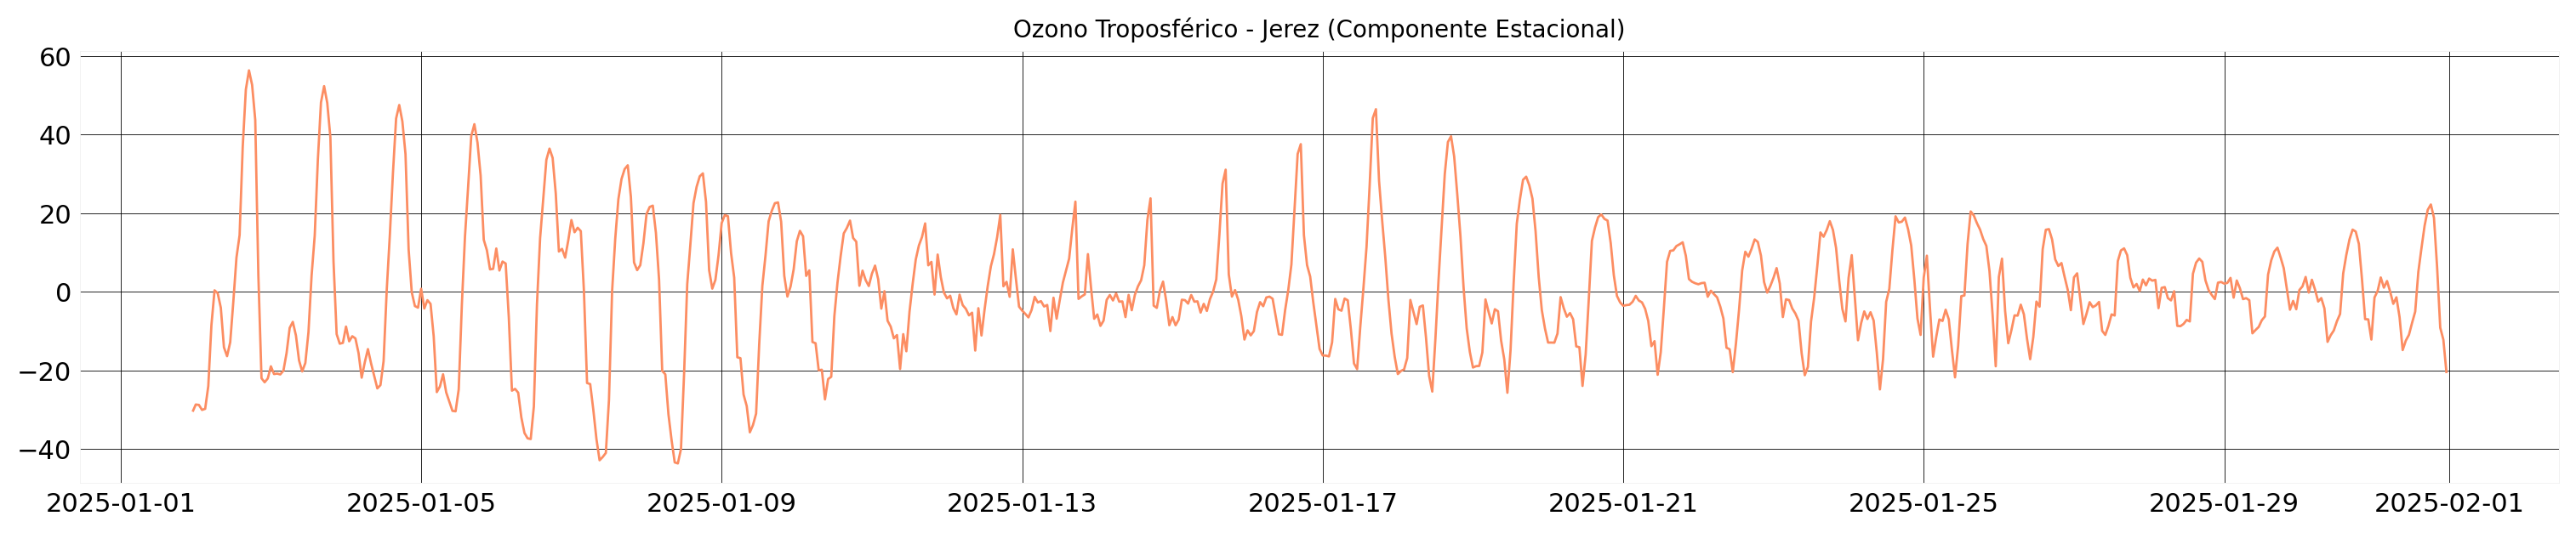

In [36]:
#Detalle componente estacional Jerez
serie_filtrada = o3_xr["2025-01-01 23:00:00":"2025-01-31 23:00:00"]
stl = STL(serie_filtrada, period=24, robust=True)
result = stl.fit()

fig, ax = plt.subplots(figsize=(15,3))
ax.plot(result.seasonal.index, result.seasonal.values)
ax.set_title('Ozono Troposférico - Jerez (Componente Estacional)', fontsize=10)
plt.tight_layout()
plt.show()

In [37]:
#Eliminamos las mediciones con fecha superior a 2025-03-11 23:00:00 ya que se ve que había una mediciones constante irreal
#para las tres estaciones. Medición -1 que al interpolar fijo un valor constante desde esa fecha/hora
corte_fecha = pd.Timestamp("2025-03-11 23:00:00")
df_merge = df_merge[df_merge["datetime"] <= corte_fecha].reset_index(drop=True)

print(df_merge["datetime"].min(), " -> ", df_merge["datetime"].max())
print(df_merge.shape)

2022-01-01 00:00:00  ->  2025-03-11 23:00:00
(83952, 13)


In [38]:
#Descargamos dataframe completo a csv
df_merge.to_csv("datos_integrados.csv", index=False, encoding="utf-8")